<a href="https://colab.research.google.com/github/jieun0441/XMC/blob/main/Time_15min_M_B_Self_containment_Calculation_dong_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## load library and dataset

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install statsmodels
import statsmodels.api as sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 13.1 MB/s eta 0:00:00


In [5]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 3.9 MB/s eta 0:00:00


### load income data

In [ ]:
#@ loading the income data
df_income = pd.read_csv('/content/drive/MyDrive/FMC_Data/Income_variable/서울시 상권분석서비스(소득소비-행정동).csv', engine = 'python', encoding = 'cp949')
df_income.rename(columns={'행정동_코드': 'dong_cd'}, inplace=True)
df_income.head(3)

,기준_년분기_코드,dong_cd,행정동_코드_명,월_평균_소득_금액,소득_구간_코드,지출_총금액,식료품_지출_총금액,의류_신발_지출_총금액,생활용품_지출_총금액,의료비_지출_총금액,교통_지출_총금액,교육_지출_총금액,유흥_지출_총금액,여가_문화_지출_총금액,기타_지출_총금액,음식_지출_총금액
0,20241,11110680,창신2동,2112817,5,378781000,114626000,2615000,3824000,54984000,1872000,1625000,6167000,8797000,7498000,176773000
1,20241,11110670,창신1동,2393308,5,885535000,150365000,56693000,1192000,227077000,754000,29247000,35303000,92980000,49143000,242781000
2,20241,11170700,보광동,2545653,6,378073000,117293000,7390000,6950000,49139000,3287000,14383000,18357000,13263000,13958000,134053000


In [ ]:
df_income.columns

Index(['기준_년분기_코드', 'dong_cd', '행정동_코드_명', '월_평균_소득_금액', '소득_구간_코드', '지출_총금액',
       '식료품_지출_총금액', '의류_신발_지출_총금액', '생활용품_지출_총금액', '의료비_지출_총금액', '교통_지출_총금액',
       '교육_지출_총금액', '유흥_지출_총금액', '여가_문화_지출_총금액', '기타_지출_총금액', '음식_지출_총금액'],
      dtype='object')

In [ ]:
# filtering time into 2023-1st semester
df_income = df_income.loc[df_income['기준_년분기_코드'] == 20231, ['dong_cd', '행정동_코드_명', '월_평균_소득_금액', '지출_총금액']]

In [ ]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Index: 425 entries, 50 to 1035
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dong_cd     425 non-null    int64 
 1   행정동_코드_명    425 non-null    object
 2   월_평균_소득_금액  425 non-null    int64 
 3   지출_총금액      425 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 16.6+ KB


In [ ]:
df_income[df_income['dong_cd'] == 11680740]

,dong_cd,행정동_코드_명,월_평균_소득_금액,지출_총금액
1031,11680740,일원2동,4553185,1437085000


In [ ]:
df_income[df_income['dong_cd'] == 11740520]

,dong_cd,행정동_코드_명,월_평균_소득_금액,지출_총금액
883,11740520,상일동,3690212,3300388000


### load registered population

In [ ]:
df_registered_pop = pd.read_excel('/content/drive/MyDrive/FMC_Data/Population_variable/Registeredpopulation_by_dong_2023_1.xlsx', )
df_registered_pop.head()

,full_dong_name,gu,dong,dong_cd,HH,regist_pop,regist_pop_per_HH,elderly_over_65,AREA_km2,pop_density
0,종로구사직동,종로구,사직동,11110530,4588,9371,1.98,1832,1.23,7618.699187
1,종로구삼청동,종로구,삼청동,11110540,1144,2616,2.02,632,1.49,1755.704698
2,종로구부암동,종로구,부암동,11110550,4122,9460,2.22,1830,2.27,4167.400881
3,종로구평창동,종로구,평창동,11110560,7248,17743,2.42,3548,8.87,2000.338219
4,종로구무악동,종로구,무악동,11110570,3014,8045,2.66,1489,0.36,22347.222222


### merge population and income

In [ ]:
# Perform an outer join to include all rows from both dataframes
merged_outer = pd.merge(df_registered_pop, df_income, on='dong_cd', how='outer', indicator=True)

# Filter out the rows that caused the unmatch
unmatched_rows = merged_outer[merged_outer['_merge'] != 'both']
unmatched_rows

,full_dong_name,gu,dong,dong_cd,HH,regist_pop,regist_pop_per_HH,elderly_over_65,AREA_km2,pop_density,행정동_코드_명,월_평균_소득_금액,지출_총금액,_merge
374,강남구개포3동,강남구,개포3동,11680675,7389.0,17186.0,2.32,3567.0,2.58,6661.240310,NaN,NaN,NaN,left_only
379,NaN,NaN,NaN,11680740,NaN,NaN,NaN,NaN,NaN,NaN,일원2동,4553185.0,1.437085e+09,right_only
409,NaN,NaN,NaN,11740520,NaN,NaN,NaN,NaN,NaN,NaN,상일동,3690212.0,3.300388e+09,right_only
410,강동구상일1동,강동구,상일1동,11740525,13601.0,39435.0,3.00,4956.0,1.82,21667.582418,NaN,NaN,NaN,left_only
411,강동구상일2동,강동구,상일2동,11740526,4856.0,12018.0,2.00,1941.0,1.09,11025.688073,NaN,NaN,NaN,left_only


In [ ]:
# replace unmatched values with proper values
merged_outer.loc[merged_outer['dong_cd'] == 11680675, '월_평균_소득_금액'] = 4553185
merged_outer.loc[merged_outer['dong_cd'] == 11680675, '지출_총금액'] = 1437085000

merged_outer.loc[merged_outer['dong_cd'] == 11740525, '월_평균_소득_금액'] = 3690212
merged_outer.loc[merged_outer['dong_cd'] == 11740525, '지출_총금액'] = 3300388000
merged_outer.loc[merged_outer['dong_cd'] == 11740526, '월_평균_소득_금액'] = 3690212
merged_outer.loc[merged_outer['dong_cd'] == 11740526, '지출_총금액'] = 3300388000

In [ ]:
# confirm replacement
unmatched_rows = merged_outer[merged_outer['_merge'] != 'both']
unmatched_rows

,full_dong_name,gu,dong,dong_cd,HH,regist_pop,regist_pop_per_HH,elderly_over_65,AREA_km2,pop_density,행정동_코드_명,월_평균_소득_금액,지출_총금액,_merge
374,강남구개포3동,강남구,개포3동,11680675,7389.0,17186.0,2.32,3567.0,2.58,6661.240310,NaN,4553185.0,1.437085e+09,left_only
379,NaN,NaN,NaN,11680740,NaN,NaN,NaN,NaN,NaN,NaN,일원2동,4553185.0,1.437085e+09,right_only
409,NaN,NaN,NaN,11740520,NaN,NaN,NaN,NaN,NaN,NaN,상일동,3690212.0,3.300388e+09,right_only
410,강동구상일1동,강동구,상일1동,11740525,13601.0,39435.0,3.00,4956.0,1.82,21667.582418,NaN,3690212.0,3.300388e+09,left_only
411,강동구상일2동,강동구,상일2동,11740526,4856.0,12018.0,2.00,1941.0,1.09,11025.688073,NaN,3690212.0,3.300388e+09,left_only


In [ ]:
merged_outer.columns

Index(['full_dong_name', 'gu', 'dong', 'dong_cd', 'HH', 'regist_pop',
       'regist_pop_per_HH', 'elderly_over_65', 'AREA_km2', 'pop_density',
       '행정동_코드_명', '월_평균_소득_금액', '지출_총금액', '_merge'],
      dtype='object')

In [ ]:
# drop right_only
donginfo_df = merged_outer[merged_outer['_merge'] != 'right_only']
# drop some columns unnecessary
donginfo_df = donginfo_df.loc[:,['full_dong_name', 'gu', 'dong', 'dong_cd', 'HH', 'regist_pop',
       'regist_pop_per_HH', 'elderly_over_65', 'AREA_km2', 'pop_density','월_평균_소득_금액', '지출_총금액']]
donginfo_df

,full_dong_name,gu,dong,dong_cd,HH,regist_pop,regist_pop_per_HH,elderly_over_65,AREA_km2,pop_density,월_평균_소득_금액,지출_총금액
0,종로구청운효자동,종로구,청운효자동,11110515,5117.0,11764.0,2.00,2172.0,2.57,4577.431907,3780222.0,2.784933e+09
1,종로구사직동,종로구,사직동,11110530,4588.0,9371.0,1.98,1832.0,1.23,7618.699187,5007768.0,5.609653e+10
2,종로구삼청동,종로구,삼청동,11110540,1144.0,2616.0,2.02,632.0,1.49,1755.704698,3442534.0,3.103159e+09
3,종로구부암동,종로구,부암동,11110550,4122.0,9460.0,2.22,1830.0,2.27,4167.400881,3647449.0,1.385759e+09
4,종로구평창동,종로구,평창동,11110560,7248.0,17743.0,2.42,3548.0,8.87,2000.338219,4504006.0,2.539729e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
423,강동구성내2동,강동구,성내2동,11740650,12710.0,23414.0,1.80,4557.0,0.92,25450.000000,2824592.0,7.468956e+09
424,강동구성내3동,강동구,성내3동,11740660,10628.0,22984.0,2.13,4142.0,1.56,14733.333333,2897346.0,7.166681e+09
425,강동구길동,강동구,길동,11740685,21917.0,45225.0,2.05,8623.0,1.61,28090.062112,2840603.0,1.261826e+10
426,강동구둔촌1동,강동구,둔촌1동,11740690,40.0,74.0,1.63,11.0,1.02,72.549020,3596734.0,2.672900e+07


In [ ]:
#@title save donginfo dataframe
donginfo_df.to_excel("/content/drive/MyDrive/FMC_Data/donginfo_df_426dongs_pop income spending.xlsx")

In [6]:
#@title load card transaction by dong
df_card = pd.read_excel("/content/drive/MyDrive/FMC_Data/Analysis_Ln T Ln Amt and Ln Defacto.xlsx")

### To jump analysis directly

In [4]:
# # dong info 1)
# donginfo_df = pd.read_excel("/content/drive/MyDrive/FMC_Data/donginfo_df_426dongs_pop income spending.xlsx")
# # indices by dong in Metropolitan area 2)
# indices_by_dong_in_Seoul = pd.read_excel("/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/indices_by_dong.xlsx")
# # 3) merged = 1) + 2)
# merged_df = pd.read_excel("/content/drive/MyDrive/FMC_Data/matched_Seoul_dong_y_and_Xvariables_with24567.xlsx")
# 4) merged = 3) + de facto population columns by time zone
#merged_df.to_excel("/content/drive/MyDrive/FMC_Data/matched_Seoul_dong_y_and_Xvariables_with_different time zone de facto populations.xlsx")
merged_df_Seoul = pd.read_excel("/content/drive/MyDrive/FMC_Data/matched_Seoul_dong_y_and_Xvariables_with_different time zone de facto populations_24567.xlsx")

In [5]:
merged_df_Seoul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         426 non-null    int64  
 1   O_ADMDONG_CD       426 non-null    int64  
 2   Self-Containment   426 non-null    float64
 3   Pull-Effect        426 non-null    float64
 4   FULL_NM            426 non-null    object 
 5   full_gu_name       426 non-null    object 
 6   SIDO_NM            426 non-null    object 
 7   SGG_NM             426 non-null    object 
 8   ADMI_NM            426 non-null    object 
 9   full_dong_name     426 non-null    object 
 10  gu                 426 non-null    object 
 11  dong               426 non-null    object 
 12  dong_cd            426 non-null    int64  
 13  HH                 426 non-null    int64  
 14  regist_pop         426 non-null    int64  
 15  regist_pop_per_HH  426 non-null    float64
 16  elderly_over_65    426 non

## Trip OD data preprocessing

### Preprocessing Step by Step Showing

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230301.csv', engine='python')
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230302.csv', engine='python')
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230303.csv', engine='python')
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230304.csv', engine='python')
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230324.csv', engine='python')

In [ ]:
df.head()

,O_ADMDONG_CD,D_ADMDONG_CD,ST_TIME_CD,FNS_TIME_CD,IN_FORN_DIV_NM,FORN_CITIZ_NM,MOVE_PURPOSE,MOVE_DIST,MOVE_TIME,CNT,ETL_YMD
0,11110515.0,11110515,0,0,내국인,ㆍ값없음,1,320.200,1.106667,2.77,20230324
1,11110515.0,11110515,0,0,내국인,ㆍ값없음,3,269.300,8.923333,3.91,20230324
2,11110515.0,11110515,0,0,내국인,한국,3,340.625,2.532500,12.87,20230324
3,11110515.0,11110515,0,0,단기외국인,ㆍ값없음,7,353.600,0.863333,3.50,20230324
4,11110515.0,11110530,0,0,내국인,ㆍ값없음,3,206.200,4.463333,1.75,20230324


In [ ]:
# Drop rows where 'O_ADMDONG_CD' or 'D_ADMDONG_CD' is "\N" or blank
df = df[(df['O_ADMDONG_CD'] != '\\N') & (df['O_ADMDONG_CD'].notnull()) & (df['D_ADMDONG_CD'] != '\\N') & (df['D_ADMDONG_CD'].notnull())]

In [ ]:
df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
df['D_ADMDONG_CD'] = df['D_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)

In [ ]:
df = df[(df['O_ADMDONG_CD'] != 0) & (df['D_ADMDONG_CD']!=0)]

In [ ]:
# keep only domestic residents
df = df[(df['IN_FORN_DIV_NM'] == "내국인")]

In [ ]:
# Create the O_SEOUL variable
df['O_SEOUL'] = df['O_ADMDONG_CD'].apply(lambda x: 1 if str(x).startswith('11') else 0)

# Create the D_SEOUL variable
df['D_SEOUL'] = df['D_ADMDONG_CD'].apply(lambda x: 1 if str(x).startswith('11') else 0)

# Filter the dataframe to keep only rows where 'O_SEOUL' is 1
df_filtered = df.loc[df['O_SEOUL'] == 1]

In [ ]:
df.head()

,O_ADMDONG_CD,D_ADMDONG_CD,ST_TIME_CD,FNS_TIME_CD,IN_FORN_DIV_NM,FORN_CITIZ_NM,MOVE_PURPOSE,MOVE_DIST,MOVE_TIME,CNT,ETL_YMD,O_SEOUL,D_SEOUL
0,11110515,11110515,0,0,내국인,ㆍ값없음,1,320.200,1.106667,2.77,20230324,1,1
1,11110515,11110515,0,0,내국인,ㆍ값없음,3,269.300,8.923333,3.91,20230324,1,1
2,11110515,11110515,0,0,내국인,한국,3,340.625,2.532500,12.87,20230324,1,1
4,11110515,11110530,0,0,내국인,ㆍ값없음,3,206.200,4.463333,1.75,20230324,1,1
5,11110515,11110530,0,0,내국인,ㆍ값없음,1,1650.000,3.643333,2.77,20230324,1,1


In [ ]:
# Filter the purpose
# School, Shopping, Sightseeing/Tourism, Hospital, Others
df_24567 = df_filtered[df_filtered['MOVE_PURPOSE'].isin([2, 4, 5, 6, 7])]

In [ ]:
#@title count by time bands
# Create a function to calculate the sum of 'CNT' for different MOVE_TIME conditions
def calculate_total_cnt(df, time_condition):
    return df.loc[time_condition, 'CNT'].sum()

# Calculate the total counts
total_cnt_15min = calculate_total_cnt(df_24567, df_24567['MOVE_TIME'] <= 15)
total_cnt_20min = calculate_total_cnt(df_24567, df_24567['MOVE_TIME'] <= 20)
total_cnt_30min = calculate_total_cnt(df_24567, df_24567['MOVE_TIME'] <= 30)
total_cnt_over30min = calculate_total_cnt(df_24567, df_24567['MOVE_TIME'] > 30)

# Create a dictionary with the sums
summary_data = {
    'total_cnt_15min': [total_cnt_15min],
    'total_cnt_20min': [total_cnt_20min],
    'total_cnt_30min': [total_cnt_30min],
    'total_cnt_over30min': [total_cnt_over30min]
}

# Convert the dictionary into a DataFrame
summary_df = pd.DataFrame(summary_data)

In [ ]:
summary_df

,total_cnt_15min,total_cnt_20min,total_cnt_30min,total_cnt_over30min
0,3357768.92,3927119.83,4876779.18,4082255.66


In [ ]:
# df['O_ADMDONG_CD'].value_counts(dropna = False).to_frame().to_excel("/content/drive/MyDrive/FMC_Data/M-B_dong_202303/O_ADMDONG_CD_value_counts_0304_after_process2.xlsx")

1: Going to Work, 2 : Going to School, 3: Going back to home, 4: Shopping, 5: Sightseeing/Tourism, 6: Hospital, 7: Others

In [ ]:
# # Add product MOVE_DIST & MOVE_TIME
# # Calculate the new variable and add it as a new column
# df['MOVE_DISTxCNT'] = df['MOVE_DIST'] * df['CNT']
# df['MOVE_TIMExCNT'] = df['MOVE_TIME'] * df['CNT']

In [ ]:
# Filter the purpose
# School, Shopping, Sightseeing/Tourism, Hospital, Others
df_24567 = df[df['MOVE_PURPOSE'].isin([2, 4, 5, 6, 7])]
# # Going to work
# df_1 = df[df['MOVE_PURPOSE']==1]
# # Going back home
# df_3 = df[df['MOVE_PURPOSE'] == 3]

In [ ]:
df_24567.head()

,O_ADMDONG_CD,D_ADMDONG_CD,ST_TIME_CD,FNS_TIME_CD,IN_FORN_DIV_NM,FORN_CITIZ_NM,MOVE_PURPOSE,MOVE_DIST,MOVE_TIME,CNT,ETL_YMD
0,11110515,11110515,0,0,내국인,한국,7,407.30,1.970000,5.22,20230301
8,11110515,11380590,0,0,내국인,한국,7,4474.90,17.473333,4.50,20230301
9,11110515,11410615,0,0,내국인,한국,7,4069.70,7.878333,2.91,20230301
11,11110530,11110515,0,0,내국인,한국,7,626.50,0.538333,2.45,20230301
16,11110530,11110530,0,0,내국인,ㆍ값없음,7,434.65,0.563333,6.10,20230301


In [ ]:
# Create a function to calculate the sum of 'CNT' for different MOVE_TIME conditions
def calculate_total_cnt(df, time_condition):
    return df.loc[time_condition, 'CNT'].sum()

# Calculate the total counts
total_cnt_15min = calculate_total_cnt(df_24567, df_24567['MOVE_TIME'] <= 15)
total_cnt_20min = calculate_total_cnt(df_24567, df_24567['MOVE_TIME'] <= 20)
total_cnt_30min = calculate_total_cnt(df_24567, df_24567['MOVE_TIME'] <= 30)
total_cnt_over30min = calculate_total_cnt(df_24567, df_24567['MOVE_TIME'] > 30)

# Create a dictionary with the sums
summary_data = {
    'total_cnt_15min': [total_cnt_15min],
    'total_cnt_20min': [total_cnt_20min],
    'total_cnt_30min': [total_cnt_30min],
    'total_cnt_over30min': [total_cnt_over30min]
}

# Convert the dictionary into a DataFrame
summary_df = pd.DataFrame(summary_data)

In [ ]:
# Display the summary table
summary_df

,total_cnt_15min,total_cnt_20min,total_cnt_30min,total_cnt_over30min
0,7465048.75,8865664.98,11057735.8,8830309.98


### Preprocessing code (Loop)

In [ ]:
#@title calculation by time bands 서울

import pandas as pd
from glob import glob

# Function to calculate total counts
def calculate_total_cnt(df, time_condition):
    return df.loc[time_condition, 'CNT'].sum()

# List to store each day's summary data
all_summaries = []

# Loop through each day of March
for day in range(1, 32):
    # Generate the filename based on the day
    file_path = f'/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_202303{day:02d}.csv'

    # Read the CSV file
    df = pd.read_csv(file_path, engine='python')

    # Filter the purpose 2,4,5,6,7 (non-work)
    df = df[df['MOVE_PURPOSE'].isin([2, 4, 5, 6, 7])]

    # Drop rows where 'O_ADMDONG_CD' or 'D_ADMDONG_CD' is "\N" or blank
    df = df[(df['O_ADMDONG_CD'] != '\\N') & df['O_ADMDONG_CD'].notnull() & (df['D_ADMDONG_CD'] != '\\N') & df['D_ADMDONG_CD'].notnull() & (df['IN_FORN_DIV_NM'] == "내국인")]

    # Convert 'O_ADMDONG_CD' and 'D_ADMDONG_CD' to integers, replacing NaN with 0 and filtering out zeros
    df.loc[:,'O_ADMDONG_CD'] = df.loc[:,'O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
    df.loc[:,'D_ADMDONG_CD'] = df.loc[:,'D_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
    df = df[(df['O_ADMDONG_CD'] != 0) & (df['D_ADMDONG_CD'] != 0)]

    # Create the O_SEOUL variable
    df.loc[:,'O_SEOUL'] = df.loc[:,'O_ADMDONG_CD'].apply(lambda x: 1 if str(x).startswith('11') else 0)

    # Create the D_SEOUL variable
    df.loc[:,'D_SEOUL'] = df.loc[:,'D_ADMDONG_CD'].apply(lambda x: 1 if str(x).startswith('11') else 0)

    # Filter the dataframe to keep only rows where 'O_SEOUL' is 1
    df = df.loc[df['O_SEOUL'] == 1]

    # Calculate the total counts
    total_cnt_15min = calculate_total_cnt(df, df['MOVE_TIME'] <= 15)
    total_cnt_20min = calculate_total_cnt(df, df['MOVE_TIME'] <= 20)
    total_cnt_30min = calculate_total_cnt(df, df['MOVE_TIME'] <= 30)
    total_cnt_over30min = calculate_total_cnt(df, df['MOVE_TIME'] > 30)

    # Append the results to the list
    all_summaries.append({
        'date': f'2023-03-{day:02d}',
        'total_cnt_15min': total_cnt_15min,
        'total_cnt_20min': total_cnt_20min,
        'total_cnt_30min': total_cnt_30min,
        'total_cnt_over30min': total_cnt_over30min
    })

# Convert the list of summaries into a DataFrame
all_summary_df = pd.DataFrame(all_summaries)

In [ ]:
# Display the final summary table
all_summary_df.to_excel("/content/drive/MyDrive/FMC_Data/Calculation_cnt_within15min_Seoul_residents_ver2.xlsx")

In [ ]:
#@title count by distance bands 서울

import pandas as pd
from glob import glob

# Function to calculate total counts
def calculate_total_cnt(df, time_condition):
    return df.loc[time_condition, 'CNT'].sum()

# List to store each day's summary data
all_summaries = []

# Loop through each day of March
for day in range(1, 32):
    # Generate the filename based on the day
    file_path = f'/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_202303{day:02d}.csv'

    # Read the CSV file
    df = pd.read_csv(file_path, engine='python')

    # Filter the purpose 2,4,5,6,7 (non-work)
    df = df[df['MOVE_PURPOSE'].isin([2, 4, 5, 6, 7])]

    # Drop rows where 'O_ADMDONG_CD' or 'D_ADMDONG_CD' is "\N" or blank
    df = df[(df['O_ADMDONG_CD'] != '\\N') & df['O_ADMDONG_CD'].notnull() & (df['D_ADMDONG_CD'] != '\\N') & df['D_ADMDONG_CD'].notnull() & (df['IN_FORN_DIV_NM'] == "내국인")]

    # Convert 'O_ADMDONG_CD' and 'D_ADMDONG_CD' to integers, replacing NaN with 0 and filtering out zeros
    df.loc[:,'O_ADMDONG_CD'] = df.loc[:,'O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
    df.loc[:,'D_ADMDONG_CD'] = df.loc[:,'D_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
    df = df[(df['O_ADMDONG_CD'] != 0) & (df['D_ADMDONG_CD'] != 0)]

    # Create the O_SEOUL variable
    df.loc[:,'O_SEOUL'] = df.loc[:,'O_ADMDONG_CD'].apply(lambda x: 1 if str(x).startswith('11') else 0)

    # Create the D_SEOUL variable
    df.loc[:,'D_SEOUL'] = df.loc[:,'D_ADMDONG_CD'].apply(lambda x: 1 if str(x).startswith('11') else 0)

    # Filter the dataframe to keep only rows where 'O_SEOUL' is 1
    df = df.loc[df['O_SEOUL'] == 1]

    # # Calculate the total counts
    # total_cnt_15min = calculate_total_cnt(df, df['MOVE_TIME'] <= 15)
    # total_cnt_20min = calculate_total_cnt(df, df['MOVE_TIME'] <= 20)
    # total_cnt_30min = calculate_total_cnt(df, df['MOVE_TIME'] <= 30)
    # total_cnt_over30min = calculate_total_cnt(df, df['MOVE_TIME'] > 30)

    # Calculate the total counts
    total_cnt_400m = calculate_total_cnt(df, df['MOVE_DIST'] <= 400)
    total_cnt_800m = calculate_total_cnt(df, df['MOVE_DIST'] <= 800)
    total_cnt_1000m = calculate_total_cnt(df, df['MOVE_DIST'] <= 1000)
    total_cnt_over1000m = calculate_total_cnt(df, df['MOVE_DIST'] > 1000)

    # Append the results to the list
    all_summaries.append({
        'date': f'2023-03-{day:02d}',
        # 'total_cnt_15min': total_cnt_15min,
        # 'total_cnt_20min': total_cnt_20min,
        # 'total_cnt_30min': total_cnt_30min,
        # 'total_cnt_over30min': total_cnt_over30min

        'total_cnt_400m': total_cnt_400m,
        'total_cnt_800m': total_cnt_800m,
        'total_cnt_1000m': total_cnt_1000m,
        'total_cnt_over1000m': total_cnt_over1000m})

# Convert the list of summaries into a DataFrame
all_summary_df = pd.DataFrame(all_summaries)
all_summary_df

,date,total_cnt_400m,total_cnt_800m,total_cnt_1000m,total_cnt_over1000m
0,2023-03-01,656236.92,1719569.94,2113649.54,4976335.50
1,2023-03-02,884622.07,2479027.44,2954326.38,5118225.68
2,2023-03-03,862182.70,2430756.15,2924268.28,5524241.07
3,2023-03-04,670896.91,1938309.99,2439013.16,6232630.44
4,2023-03-05,634821.79,1729481.06,2148562.14,5095734.95
5,2023-03-06,896408.17,2427224.75,2881133.83,4871184.82
6,2023-03-07,908725.59,2498783.62,2966337.65,5141766.50
7,2023-03-08,912038.69,2496776.82,2953727.66,5138028.58
8,2023-03-09,918084.48,2456535.52,2913959.29,5090823.32
9,2023-03-10,885296.93,2514870.95,3033425.90,5724396.42


In [ ]:
# Display the final summary table
all_summary_df.to_excel("/content/drive/MyDrive/FMC_Data/Calculation_cnt_within_distance_Seoul_residents_ver2.xlsx")

In [ ]:
#@title distance bands with 수도권 전체
#@title count by distance bands
import pandas as pd
from glob import glob

# Function to calculate total counts
def calculate_total_cnt(df, time_condition):
    return df.loc[time_condition, 'CNT'].sum()

# List to store each day's summary data
all_summaries = []

# Loop through each day of March
for day in range(1, 32):
    # Generate the filename based on the day
    file_path = f'/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_202303{day:02d}.csv'

    # Read the CSV file
    df = pd.read_csv(file_path, engine='python')

    # Filter the purpose 2,4,5,6,7 (non-work)
    df = df[df['MOVE_PURPOSE'].isin([2, 4, 5, 6, 7])]

    # Drop rows where 'O_ADMDONG_CD' or 'D_ADMDONG_CD' is "\N" or blank
    df = df[(df['O_ADMDONG_CD'] != '\\N') & df['O_ADMDONG_CD'].notnull() & (df['D_ADMDONG_CD'] != '\\N') & df['D_ADMDONG_CD'].notnull() & (df['IN_FORN_DIV_NM'] == "내국인")]

    # Convert 'O_ADMDONG_CD' and 'D_ADMDONG_CD' to integers, replacing NaN with 0 and filtering out zeros
    df.loc[:,'O_ADMDONG_CD'] = df.loc[:,'O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
    df.loc[:,'D_ADMDONG_CD'] = df.loc[:,'D_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
    df = df[(df['O_ADMDONG_CD'] != 0) & (df['D_ADMDONG_CD'] != 0)]

    # # Create the O_SEOUL variable
    # df.loc[:,'O_SEOUL'] = df.loc[:,'O_ADMDONG_CD'].apply(lambda x: 1 if str(x).startswith('11') else 0)

    # # Create the D_SEOUL variable
    # df.loc[:,'D_SEOUL'] = df.loc[:,'D_ADMDONG_CD'].apply(lambda x: 1 if str(x).startswith('11') else 0)

    # # Filter the dataframe to keep only rows where 'O_SEOUL' is 1
    # df = df.loc[df['O_SEOUL'] == 1]

    # # Calculate the total counts
    # total_cnt_15min = calculate_total_cnt(df, df['MOVE_TIME'] <= 15)
    # total_cnt_20min = calculate_total_cnt(df, df['MOVE_TIME'] <= 20)
    # total_cnt_30min = calculate_total_cnt(df, df['MOVE_TIME'] <= 30)
    # total_cnt_over30min = calculate_total_cnt(df, df['MOVE_TIME'] > 30)

    # Calculate the total counts
    total_cnt_400m = calculate_total_cnt(df, df['MOVE_DIST'] <= 400)
    total_cnt_800m = calculate_total_cnt(df, df['MOVE_DIST'] <= 800)
    total_cnt_1000m = calculate_total_cnt(df, df['MOVE_DIST'] <= 1000)
    total_cnt_over1000m = calculate_total_cnt(df, df['MOVE_DIST'] > 1000)

    # Append the results to the list
    all_summaries.append({
        'date': f'2023-03-{day:02d}',
        # 'total_cnt_15min': total_cnt_15min,
        # 'total_cnt_20min': total_cnt_20min,
        # 'total_cnt_30min': total_cnt_30min,
        # 'total_cnt_over30min': total_cnt_over30min

        'total_cnt_400m': total_cnt_400m,
        'total_cnt_800m': total_cnt_800m,
        'total_cnt_1000m': total_cnt_1000m,
        'total_cnt_over1000m': total_cnt_over1000m})

# Convert the list of summaries into a DataFrame
all_summary_df = pd.DataFrame(all_summaries)
all_summary_df

,date,total_cnt_400m,total_cnt_800m,total_cnt_1000m,total_cnt_over1000m
0,2023-03-01,1043406.68,3507338.96,4524161.89,15363883.89
1,2023-03-02,1371776.67,4879392.93,6124169.91,14966487.57
2,2023-03-03,1336838.89,4818424.36,6098120.53,16095395.14
3,2023-03-04,1051632.06,3889876.86,5146810.22,18542417.94
4,2023-03-05,1013439.80,3541598.53,4636431.52,15508933.15
5,2023-03-06,1386335.04,4786657.90,5976190.93,14395133.10
6,2023-03-07,1390654.97,4882213.53,6088142.77,15027669.04
7,2023-03-08,1401922.92,4889116.17,6089535.86,14967029.34
8,2023-03-09,1404811.31,4813747.86,6003487.10,14868498.67
9,2023-03-10,1369321.38,4977239.44,6295225.86,16576456.10


In [ ]:
# Display the final summary table
all_summary_df.to_excel("/content/drive/MyDrive/FMC_Data/Calculation_cnt_within_distance_SMA_residents_ver2.xlsx")

In [ ]:
# Define the file path template
path_template = "/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_202303{:02d}.csv"
output_path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_count dist time_each day_3/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_2303{:02d}.csv"
count_output_path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_count_each day_3/Aggregated_Dong_OD_1)Numtrip_2303{:02d}.csv"
work_output_path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_work_each day_3/Aggregated_Dong_Work_OD_2303{:02d}.csv"

# Loop over the files
for day in range(1, 32):  # Assuming files are numbered from 01 to 31
    path = path_template.format(day)
    df = pd.read_csv(path, engine='python')

    # preprocessing steps
    # Drop rows where 'O_ADMDONG_CD' or 'D_ADMDONG_CD' is "\N" or blank
    df = df[(df['O_ADMDONG_CD'] != '\\N') & (df['O_ADMDONG_CD'].notnull()) & (df['D_ADMDONG_CD'] != '\\N') & (df['D_ADMDONG_CD'].notnull())]
    df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int) # df.loc[:, 'O_ADMDONG_CD']
    df['D_ADMDONG_CD'] = df['D_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int) # df.loc[:, 'D_ADMDONG_CD']
    df = df[(df['O_ADMDONG_CD'] != 0) & (df['D_ADMDONG_CD']!=0)]

    # Add product MOVE_DIST & MOVE_TIME
    # Calculate the new variable and add it as a new column
    df['MOVE_DISTxCNT'] = df['MOVE_DIST'] * df['CNT']
    df['MOVE_TIMExCNT'] = df['MOVE_TIME'] * df['CNT']

    # Filter the purpose
    df_24567 = df[df['MOVE_PURPOSE'].isin([2, 4, 5, 6, 7])]
    df_1 = df[df['MOVE_PURPOSE'] == 1]
    df_3 = df[df['MOVE_PURPOSE'] == 3]

    # Aggregate the dataset
    # Aggregating purpose 2,4,5,6,7 (all except going to work(1) and coming back to home(3)) trip
    aggregated_df_24567 = df_24567.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
        'CNT': 'sum',
        'MOVE_DISTxCNT': 'sum',
        'MOVE_TIMExCNT': 'sum'
    }).reset_index()

    # Aggregating purpose 1 (going to work) trip
    aggregated_df_1 = df_1.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
        'CNT': 'sum',
        'MOVE_DISTxCNT': 'sum',
        'MOVE_TIMExCNT': 'sum'
    }).reset_index()

    # Merge the two aggregated DataFrames on ['O_ADMDONG_CD', 'D_ADMDONG_CD']
    merged_df = pd.merge(aggregated_df_24567, aggregated_df_1, on=['O_ADMDONG_CD', 'D_ADMDONG_CD'], suffixes=('_24567', '_1'), how='left')

    # Fill NaN values with 0 (in case there are no purpose 1 trips for some O-D pairs)
    merged_df = merged_df.fillna(0)

    # Aggregating purpose 3 (coming back to home) trip
    aggregated_df_3 = df_3.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
        'CNT': 'sum',
        'MOVE_DISTxCNT': 'sum',
        'MOVE_TIMExCNT': 'sum'
    }).reset_index()

    # Rename columns to add the _3 suffix
    aggregated_df_3.rename(columns={
        'CNT': 'CNT_3',
        'MOVE_DISTxCNT': 'MOVE_DISTxCNT_3',
        'MOVE_TIMExCNT': 'MOVE_TIMExCNT_3'
    }, inplace=True)

    # Merge the aggregated_df_3 with the merged_df that contains RT-NonWork data
    final_merged_df = pd.merge(merged_df, aggregated_df_3, on=['O_ADMDONG_CD', 'D_ADMDONG_CD'], how='left')

    # Select relevant columns for the final DataFrame
    final_df = final_merged_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_24567', 'CNT_1', 'CNT_3','MOVE_TIMExCNT_24567', 'MOVE_TIMExCNT_1', 'MOVE_TIMExCNT_3', 'MOVE_DISTxCNT_24567', 'MOVE_DISTxCNT_1', 'MOVE_DISTxCNT_3']]

    # Reorder the columns in the final DataFrame
    final_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_1', 'CNT_3', 'CNT_24567',
                         'MOVE_TIMExCNT_1', 'MOVE_TIMExCNT_3', 'MOVE_TIMExCNT_24567',
                         'MOVE_DISTxCNT_1', 'MOVE_DISTxCNT_3', 'MOVE_DISTxCNT_24567']]

    # add and work trip-related columns and non-work trip-related columns separately
    count_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD','CNT_1', 'CNT_3', 'CNT_24567']]
    time_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD','MOVE_TIMExCNT_1', 'MOVE_TIMExCNT_3', 'MOVE_TIMExCNT_24567']]
    work_related_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_1', 'MOVE_DISTxCNT_1', 'MOVE_TIMExCNT_1']]

    # Save the final DataFrames
    output_path = output_path_template.format(day)
    count_output_path = count_output_path_template.format(day)
    work_output_path = work_output_path_template.format(day)
    final_df.to_csv(output_path, index=False)
    count_df.to_csv(count_output_path, index=False)
    work_related_df.to_csv(work_output_path, index=False)

<ipython-input-3-ad231ca5bdd0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
<ipython-input-3-ad231ca5bdd0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
<ipython-input-3-ad231ca5bdd0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

### Concatenating Codes


#### load aggregated Num Dist Time data and combine those

In [ ]:
# Define the file path template
path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated count dist time each day_2/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_2303{:02d}.csv"

# Create a list to store all data frames
df_list = []

# Loop over the files
for day in range(1, 32):  # Assuming files are numbered from 01 to 31
    path = path_template.format(day)
    df = pd.read_csv(path, engine='python')
    df_list.append(df)  # Add the current data frame to the list

In [ ]:
# Loop over the list and print the data type of 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
for i, df in enumerate(df_list, start=1):
    print(f"DataFrame df{i}:")
    print(f"O_ADMDONG_CD dtype: {df['O_ADMDONG_CD'].dtype}")
    print(f"D_ADMDONG_CD dtype: {df['D_ADMDONG_CD'].dtype}")
    print()

DataFrame df1:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df2:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df3:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df4:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df5:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df6:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df7:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df8:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df9:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df10:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df11:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df12:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df13:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df14:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df15:
O_ADMDONG_CD dtype: int64
D

In [ ]:
# Concatenate all the DataFrames in the list
big_df_noNan = pd.concat(df_list, ignore_index=True)

In [ ]:
# Check for the presence of '\\N'
contains_N = '\\N' in big_df_noNan['O_ADMDONG_CD'].values

# Print the results
print(f"Contains '\\N': {contains_N}")

Contains '\N': False


In [ ]:
# Check for the presence of '\\N'
contains_N = '\\N' in big_df_noNan['D_ADMDONG_CD'].values

# Print the results
print(f"Contains '\\N': {contains_N}")

Contains '\N': False


In [ ]:
# Aggregate each column by 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
aggregated_df = big_df_noNan.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT_1': 'sum',
    'CNT_3': 'sum',
    'CNT_24567': 'sum',
    'MOVE_DISTxCNT_1': 'sum',
    'MOVE_DISTxCNT_3': 'sum',
    'MOVE_DISTxCNT_24567': 'sum',
    'MOVE_TIMExCNT_1': 'sum',
    'MOVE_TIMExCNT_3': 'sum',
    'MOVE_TIMExCNT_24567': 'sum',
    'RT-NonWork_CNT': 'sum',
    'RT-NonWork_MOVE_DISTxCNT': 'sum',
    'RT-NonWork_MOVE_TIMExCNT': 'sum',
    'RT-Work_CNT': 'sum',
    'RT-Work_MOVE_DISTxCNT': 'sum',
    'RT-Work_MOVE_TIMExCNT': 'sum'
}).reset_index()

# Calculate the Average distance and times
aggregated_df['Avg_DIST_1'] = aggregated_df['MOVE_DISTxCNT_1']/aggregated_df['CNT_1']
aggregated_df['Avg_DIST_3'] = aggregated_df['MOVE_DISTxCNT_3']/aggregated_df['CNT_3']
aggregated_df['Avg_DIST_24567'] = aggregated_df['MOVE_DISTxCNT_24567']/aggregated_df['CNT_24567']
aggregated_df['Avg_RT_NonWork_DIST'] = aggregated_df['RT-NonWork_MOVE_DISTxCNT']/aggregated_df['RT-NonWork_CNT']
aggregated_df['Avg_RT_Work_DIST'] = aggregated_df['RT-Work_MOVE_DISTxCNT']/aggregated_df['RT-Work_CNT']

aggregated_df['Avg_TIME_1'] = aggregated_df['MOVE_TIMExCNT_1']/aggregated_df['CNT_1']
aggregated_df['Avg_TIME_3'] = aggregated_df['MOVE_TIMExCNT_3']/aggregated_df['CNT_3']
aggregated_df['Avg_TIME_24567'] = aggregated_df['MOVE_TIMExCNT_24567']/aggregated_df['CNT_24567']
aggregated_df['Avg_RT_NonWork_TIME'] = aggregated_df['RT-NonWork_MOVE_TIMExCNT']/aggregated_df['RT-NonWork_CNT']
aggregated_df['Avg_RT_Work_TIME'] = aggregated_df['RT-Work_MOVE_TIMExCNT']/aggregated_df['RT-Work_CNT']

In [ ]:
# save the aggregated DataFrame to a new CSV file
aggregated_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_COUNT_Dong-Dong count dist time_2023_03_ver2.csv', index=False)

In [ ]:
aggregated_df.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,MOVE_DISTxCNT_1,MOVE_DISTxCNT_3,MOVE_DISTxCNT_24567,MOVE_TIMExCNT_1,MOVE_TIMExCNT_3,...,Avg_DIST_1,Avg_DIST_3,Avg_DIST_24567,Avg_RT_NonWork_DIST,Avg_RT_Work_DIST,Avg_TIME_1,Avg_TIME_3,Avg_TIME_24567,Avg_RT_NonWork_TIME,Avg_RT_Work_TIME
0,11110515,11110515,13045.84,52744.40,139766.81,5.762448e+06,2.384616e+07,7.622389e+07,202241.584854,935913.259475,...,441.707717,452.107828,545.364764,556.036188,630.135852,15.502381,17.744315,16.657959,16.776925,16.087187
1,11110515,11110530,11888.65,12368.02,108223.86,1.093979e+07,9.636553e+06,9.889134e+07,196172.996056,272984.440617,...,920.188156,779.150815,913.766482,912.973988,932.685588,16.500864,22.071798,22.247274,22.956434,23.086737
2,11110515,11110540,1498.43,2483.60,27594.13,1.694384e+06,2.434766e+06,2.791596e+07,34178.196937,47006.789224,...,1130.772783,980.337236,1011.662876,1004.823518,1007.399067,22.809338,18.926876,23.287716,23.315185,23.776762
3,11110515,11110550,1207.86,12662.17,14987.79,2.321612e+06,2.502406e+07,2.602437e+07,30283.334936,340036.886143,...,1922.087022,1976.284891,1736.371488,1720.092859,-1182.092825,25.071892,26.854551,22.120367,21.861655,-34.698690
4,11110515,11110560,1033.45,12025.93,7057.94,3.155446e+06,3.440110e+07,2.041584e+07,25791.165847,382875.122837,...,3053.313100,2860.576771,2892.606538,2865.038695,2856.097710,24.956375,31.837465,28.564834,29.183835,34.501287


In [ ]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204373 entries, 0 to 3204372
Data columns (total 27 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   O_ADMDONG_CD              int64  
 1   D_ADMDONG_CD              int64  
 2   CNT_1                     float64
 3   CNT_3                     float64
 4   CNT_24567                 float64
 5   MOVE_DISTxCNT_1           float64
 6   MOVE_DISTxCNT_3           float64
 7   MOVE_DISTxCNT_24567       float64
 8   MOVE_TIMExCNT_1           float64
 9   MOVE_TIMExCNT_3           float64
 10  MOVE_TIMExCNT_24567       float64
 11  RT-NonWork_CNT            float64
 12  RT-NonWork_MOVE_DISTxCNT  float64
 13  RT-NonWork_MOVE_TIMExCNT  float64
 14  RT-Work_CNT               float64
 15  RT-Work_MOVE_DISTxCNT     float64
 16  RT-Work_MOVE_TIMExCNT     float64
 17  Avg_DIST_1                float64
 18  Avg_DIST_3                float64
 19  Avg_DIST_24567            float64
 20  Avg_RT_NonWork_DIST     

#### count data frame concatenating

In [ ]:
# 1)NumTrip만 있는 데이터
# Define the file path template
path_template_1 = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_count_each day_2/Aggregated_Dong_OD_1)Numtrip_2303{:02d}.csv"

# Create a list to store all data frames
df_list_count_dfs = []

# Loop over the files
for day in range(1, 32):  # Assuming files are numbered from 01 to 31
    path = path_template_1.format(day)
    df = pd.read_csv(path, engine='python')
    df_list_count_dfs.append(df)  # Add the current data frame to the list

In [ ]:
# Concatenate all the DataFrames in the list
big_df_noNan_count = pd.concat(df_list_count_dfs, ignore_index=True)

In [ ]:
big_df_noNan_count.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,RT-NonWork_CNT,RT-Work_CNT
0,11110515,11110515,284.56,1368.74,4820.87,4536.31,-3167.57
1,11110515,11110530,178.83,360.70,4323.70,4144.87,-3784.17
2,11110515,11110540,27.04,78.61,1313.01,1285.97,-1207.36
3,11110515,11110550,8.00,212.45,555.20,547.20,-334.75
4,11110515,11110560,10.86,247.46,181.50,170.64,76.82


In [ ]:
# Aggregate each column by 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
aggregated_df_count = big_df_noNan_count.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT_1': 'sum',
    'CNT_3': 'sum',
    'CNT_24567': 'sum',
    'RT-NonWork_CNT': 'sum',
    'RT-Work_CNT': 'sum',
}).reset_index()

aggregated_df_count.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,RT-NonWork_CNT,RT-Work_CNT
0,11110515,11110515,13045.84,52744.40,139766.81,126720.97,-73976.57
1,11110515,11110530,11888.65,12368.02,108223.86,96335.21,-83967.19
2,11110515,11110540,1498.43,2483.60,27594.13,26095.70,-23612.10
3,11110515,11110550,1207.86,12662.17,14987.79,13779.93,-1117.76
4,11110515,11110560,1033.45,12025.93,7057.94,6024.49,6001.44


In [ ]:
aggregated_df_count.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Dong-Dong count_2023_03_ver2.csv', index=False)

In [ ]:
aggregated_df_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204373 entries, 0 to 3204372
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   O_ADMDONG_CD    int64  
 1   D_ADMDONG_CD    int64  
 2   CNT_1           float64
 3   CNT_3           float64
 4   CNT_24567       float64
 5   RT-NonWork_CNT  float64
 6   RT-Work_CNT     float64
dtypes: float64(5), int64(2)
memory usage: 171.1 MB


#### work data concatenating

In [ ]:
# work related data
# Define the file path template
path_template_2 = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_work_each day_2/Aggregated_Dong_Work_OD_2303{:02d}.csv"

# Create a list to store all data frames
df_list_work_dfs = []

# Loop over the files
for day in range(1, 32):  # Assuming files are numbered from 01 to 31
    path = path_template_2.format(day)
    df = pd.read_csv(path, engine='python')
    df_list_work_dfs.append(df)  # Add the current data frame to the list

In [ ]:
# Concatenate all the DataFrames in the list
big_df_noNan_work = pd.concat(df_list_work_dfs, ignore_index=True)

In [ ]:
big_df_noNan_work.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,MOVE_DISTxCNT_1,MOVE_TIMExCNT_1,RT-Work_CNT,RT-Work_MOVE_DISTxCNT,RT-Work_MOVE_TIMExCNT
0,11110515,11110515,284.56,109549.510095,5965.419822,-3167.57,-2.370552e+06,-47698.825285
1,11110515,11110530,178.83,170558.055333,4212.511008,-3784.17,-3.814989e+06,-99329.313177
2,11110515,11110540,27.04,26986.755000,357.353517,-1207.36,-1.175146e+06,-29104.742131
3,11110515,11110550,8.00,13774.779000,59.157267,-334.75,-4.163718e+05,-5357.646583
4,11110515,11110560,10.86,27939.470000,544.838700,76.82,2.124666e+05,2961.652415


In [ ]:
# Aggregate each column by 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
aggregated_df_work = big_df_noNan_work.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT_1': 'sum',
    'MOVE_DISTxCNT_1': 'sum',
    'MOVE_TIMExCNT_1': 'sum',
    'RT-Work_CNT': 'sum',
    'RT-Work_MOVE_DISTxCNT': 'sum',
    'RT-Work_MOVE_TIMExCNT': 'sum'
}).reset_index()

# Calculate the Average distance and times
aggregated_df_work['Avg_DIST_1'] = aggregated_df_work['MOVE_DISTxCNT_1']/aggregated_df_work['CNT_1']
aggregated_df_work['Avg_RT_Work_DIST'] = aggregated_df_work['RT-Work_MOVE_DISTxCNT']/aggregated_df_work['RT-Work_CNT']
aggregated_df_work['Avg_TIME_1'] = aggregated_df_work['MOVE_TIMExCNT_1']/aggregated_df_work['CNT_1']
aggregated_df_work['Avg_RT_Work_TIME'] = aggregated_df_work['RT-Work_MOVE_TIMExCNT']/aggregated_df_work['RT-Work_CNT']

# save the aggregated DataFrame to a new CSV file
aggregated_df_work.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Work_Dong-Dong_2023_03_ver2.csv', index=False)

In [ ]:
big_df_noNan_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25824799 entries, 0 to 25824798
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   O_ADMDONG_CD           int64  
 1   D_ADMDONG_CD           int64  
 2   CNT_1                  float64
 3   MOVE_DISTxCNT_1        float64
 4   MOVE_TIMExCNT_1        float64
 5   RT-Work_CNT            float64
 6   RT-Work_MOVE_DISTxCNT  float64
 7   RT-Work_MOVE_TIMExCNT  float64
dtypes: float64(6), int64(2)
memory usage: 1.5 GB


### Calculate Self-containment and Pull-Effect

#### load Count data

In [ ]:
# load count aggregated data
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Dong-Dong count_2023_03.csv')
df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Dong-Dong count_2023_03_ver2.csv')

In [ ]:
df['RT-NonWork_CNT'] = df['CNT_24567']

In [ ]:
df.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,RT-NonWork_CNT,RT-Work_CNT
0,11110515,11110515,13045.84,52744.40,139766.81,139766.81,-73976.57
1,11110515,11110530,11888.65,12368.02,108223.86,108223.86,-83967.19
2,11110515,11110540,1498.43,2483.60,27594.13,27594.13,-23612.10
3,11110515,11110550,1207.86,12662.17,14987.79,14987.79,-1117.76
4,11110515,11110560,1033.45,12025.93,7057.94,7057.94,6001.44


In [ ]:
# # Replace negative 'RT-NonWork_CNT' values with 0
# merged_df.loc[merged_df['RT-NonWork_CNT'] < 0, 'RT-NonWork_CNT'] = 0

In [ ]:
# Calculate total non-work trips for each origin
total_origin_trips = df.groupby('O_ADMDONG_CD')['RT-NonWork_CNT'].sum()

# Calculate total non-work trips where origin = destination
self_trips = df[df['O_ADMDONG_CD'] == df['D_ADMDONG_CD']].groupby('O_ADMDONG_CD')['RT-NonWork_CNT'].sum()

# Calculate self-containment for each area
self_containment = self_trips / total_origin_trips
self_containment = self_containment.fillna(0)  # fill NaN values with 0

In [ ]:
# Calculate total non-work trips for each destination, excluding trips where origin = destination
filtered_df = df[df['O_ADMDONG_CD'] != df['D_ADMDONG_CD']]
total_trips = filtered_df['RT-NonWork_CNT'].sum()
destination_trips = df[df['O_ADMDONG_CD'] != df['D_ADMDONG_CD']].groupby('D_ADMDONG_CD')['RT-NonWork_CNT'].sum()
pull_effect = destination_trips / total_trips * 100
# Convert the result to a DataFrame for better readability
pull_effect_df = pull_effect.reset_index()
pull_effect_df.columns = ['D_ADMDONG_CD', 'Pull-Effect']

In [ ]:
pull_effect_df

,D_ADMDONG_CD,Pull-Effect
0,11110515,0.108495
1,11110530,0.218479
2,11110540,0.063439
3,11110550,0.056799
4,11110560,0.053817
...,...,...
3518,50130580,0.000098
3519,50130590,0.000615
3520,50130600,0.000510
3521,50130610,0.000723


In [ ]:
pull_effect = pull_effect.fillna(0)  # fill NaN values with 0

In [ ]:
self_containment.index

Index([11110515, 11110530, 11110540, 11110550, 11110560, 11110570, 11110580,
       11110600, 11110615, 11110630,
       ...
       50130530, 50130540, 50130550, 50130560, 50130570, 50130580, 50130590,
       50130600, 50130610, 50130620],
      dtype='int64', name='O_ADMDONG_CD', length=3523)

In [ ]:
df_indices = pd.DataFrame({
    'O_ADMDONG_CD': self_containment.index,
    'Self-Containment': self_containment.values,
    'Pull-Effect': pull_effect.reindex(self_containment.index).values # Reindex to align with self_containment
})

In [ ]:
# filtering out inf pull-effect and zero self-containment
df_indices = df_indices.replace([np.inf, -np.inf], np.nan)  # replace 'inf' with NaN
df_indices = df_indices[(df_indices['Self-Containment'] != 0) & (df_indices['Pull-Effect'].notna())]

In [ ]:
df_indices

,O_ADMDONG_CD,Self-Containment,Pull-Effect
0,11110515,0.169078,0.108495
1,11110530,0.111614,0.218479
2,11110540,0.064625,0.063439
3,11110550,0.172747,0.056799
4,11110560,0.171173,0.053817
...,...,...,...
1747,41830370,0.201316,0.008990
1748,41830380,0.245172,0.025545
1749,41830395,0.229078,0.018493
1750,41830400,0.446933,0.060641


In [ ]:
#@title load dong code name
df_name = pd.read_csv('/content/drive/MyDrive/FMC_Data/ADMI_202303.csv')

In [ ]:
# Combine 'sido' and 'gu' columns with a space in between
df_name['full_gu_name'] = df_name['SIDO_NM'] + ' ' + df_name['SGG_NM']
df_name.head()

,SIDO_NM,SGG_NM,ADMI_NM,ADMI_CD,FULL_NM,BASE_YM,full_gu_name
0,서울특별시,종로구,청운효자동,11110515,서울특별시 종로구 청운효자동,202303,서울특별시 종로구
1,서울특별시,종로구,사직동,11110530,서울특별시 종로구 사직동,202303,서울특별시 종로구
2,서울특별시,종로구,삼청동,11110540,서울특별시 종로구 삼청동,202303,서울특별시 종로구
3,서울특별시,종로구,부암동,11110550,서울특별시 종로구 부암동,202303,서울특별시 종로구
4,서울특별시,종로구,평창동,11110560,서울특별시 종로구 평창동,202303,서울특별시 종로구


In [ ]:
# Merge origin dong's gu name on the df_indices
selected_cols_to_merge = ['ADMI_CD', 'FULL_NM', 'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM']
merged_df = pd.merge(df_indices, df_name[selected_cols_to_merge], left_on = 'O_ADMDONG_CD', right_on = 'ADMI_CD', how = 'left')
merged_df = merged_df.drop(columns=['ADMI_CD'])
merged_df.head()

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM
0,11110515,0.169078,0.108495,서울특별시 종로구 청운효자동,서울특별시 종로구,서울특별시,종로구,청운효자동
1,11110530,0.111614,0.218479,서울특별시 종로구 사직동,서울특별시 종로구,서울특별시,종로구,사직동
2,11110540,0.064625,0.063439,서울특별시 종로구 삼청동,서울특별시 종로구,서울특별시,종로구,삼청동
3,11110550,0.172747,0.056799,서울특별시 종로구 부암동,서울특별시 종로구,서울특별시,종로구,부암동
4,11110560,0.171173,0.053817,서울특별시 종로구 평창동,서울특별시 종로구,서울특별시,종로구,평창동


In [ ]:
# merged_df.to_excel('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/indices_by_dong.xlsx', index=False)
merged_df.to_excel('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/indices_with24567_by_dong.xlsx', index=False)

## Join donginfo table and indices table

In [ ]:
# donginfo data look
donginfo_df.head()

,Unnamed: 0,full_dong_name,gu,dong,dong_cd,HH,regist_pop,regist_pop_per_HH,elderly_over_65,AREA_km2,pop_density,월_평균_소득_금액,지출_총금액
0,0,종로구청운효자동,종로구,청운효자동,11110515,5117,11764,2.00,2172,2.57,4577.431907,3780222,2784933000
1,1,종로구사직동,종로구,사직동,11110530,4588,9371,1.98,1832,1.23,7618.699187,5007768,56096531000
2,2,종로구삼청동,종로구,삼청동,11110540,1144,2616,2.02,632,1.49,1755.704698,3442534,3103159000
3,3,종로구부암동,종로구,부암동,11110550,4122,9460,2.22,1830,2.27,4167.400881,3647449,1385759000
4,4,종로구평창동,종로구,평창동,11110560,7248,17743,2.42,3548,8.87,2000.338219,4504006,2539729000


In [ ]:
donginfo_df.rename(columns={'Unnamed: 0': 'O_ADMDONG_CD'}, inplace=True)

In [ ]:
donginfo_df['O_ADMDONG_CD'] = donginfo_df['dong_cd']

In [ ]:
donginfo_df.head()

,O_ADMDONG_CD,full_dong_name,gu,dong,dong_cd,HH,regist_pop,regist_pop_per_HH,elderly_over_65,AREA_km2,pop_density,월_평균_소득_금액,지출_총금액
0,11110515,종로구청운효자동,종로구,청운효자동,11110515,5117,11764,2.00,2172,2.57,4577.431907,3780222,2784933000
1,11110530,종로구사직동,종로구,사직동,11110530,4588,9371,1.98,1832,1.23,7618.699187,5007768,56096531000
2,11110540,종로구삼청동,종로구,삼청동,11110540,1144,2616,2.02,632,1.49,1755.704698,3442534,3103159000
3,11110550,종로구부암동,종로구,부암동,11110550,4122,9460,2.22,1830,2.27,4167.400881,3647449,1385759000
4,11110560,종로구평창동,종로구,평창동,11110560,7248,17743,2.42,3548,8.87,2000.338219,4504006,2539729000


In [ ]:
merged_df.head()

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM
0,11110515,0.169078,0.108495,서울특별시 종로구 청운효자동,서울특별시 종로구,서울특별시,종로구,청운효자동
1,11110530,0.111614,0.218479,서울특별시 종로구 사직동,서울특별시 종로구,서울특별시,종로구,사직동
2,11110540,0.064625,0.063439,서울특별시 종로구 삼청동,서울특별시 종로구,서울특별시,종로구,삼청동
3,11110550,0.172747,0.056799,서울특별시 종로구 부암동,서울특별시 종로구,서울특별시,종로구,부암동
4,11110560,0.171173,0.053817,서울특별시 종로구 평창동,서울특별시 종로구,서울특별시,종로구,평창동


In [ ]:
#@title Perform outer join
merged_df = pd.merge(merged_df, donginfo_df, on = 'O_ADMDONG_CD', how = 'outer', indicator = True)
merged_df.head()

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM,full_dong_name,gu,...,dong_cd,HH,regist_pop,regist_pop_per_HH,elderly_over_65,AREA_km2,pop_density,월_평균_소득_금액,지출_총금액,_merge
0,11110515,0.169078,0.108495,서울특별시 종로구 청운효자동,서울특별시 종로구,서울특별시,종로구,청운효자동,종로구청운효자동,종로구,...,11110515.0,5117.0,11764.0,2.00,2172.0,2.57,4577.431907,3780222.0,2.784933e+09,both
1,11110530,0.111614,0.218479,서울특별시 종로구 사직동,서울특별시 종로구,서울특별시,종로구,사직동,종로구사직동,종로구,...,11110530.0,4588.0,9371.0,1.98,1832.0,1.23,7618.699187,5007768.0,5.609653e+10,both
2,11110540,0.064625,0.063439,서울특별시 종로구 삼청동,서울특별시 종로구,서울특별시,종로구,삼청동,종로구삼청동,종로구,...,11110540.0,1144.0,2616.0,2.02,632.0,1.49,1755.704698,3442534.0,3.103159e+09,both
3,11110550,0.172747,0.056799,서울특별시 종로구 부암동,서울특별시 종로구,서울특별시,종로구,부암동,종로구부암동,종로구,...,11110550.0,4122.0,9460.0,2.22,1830.0,2.27,4167.400881,3647449.0,1.385759e+09,both
4,11110560,0.171173,0.053817,서울특별시 종로구 평창동,서울특별시 종로구,서울특별시,종로구,평창동,종로구평창동,종로구,...,11110560.0,7248.0,17743.0,2.42,3548.0,8.87,2000.338219,4504006.0,2.539729e+09,both


In [ ]:
merged_df = merged_df[ merged_df['_merge'] == 'both']

In [ ]:
#@title save matched Seoul dong y and X variables
merged_df.to_excel("/content/drive/MyDrive/FMC_Data/matched_Seoul_dong_y_and_Xvariables_with24567.xlsx")

# Analysis

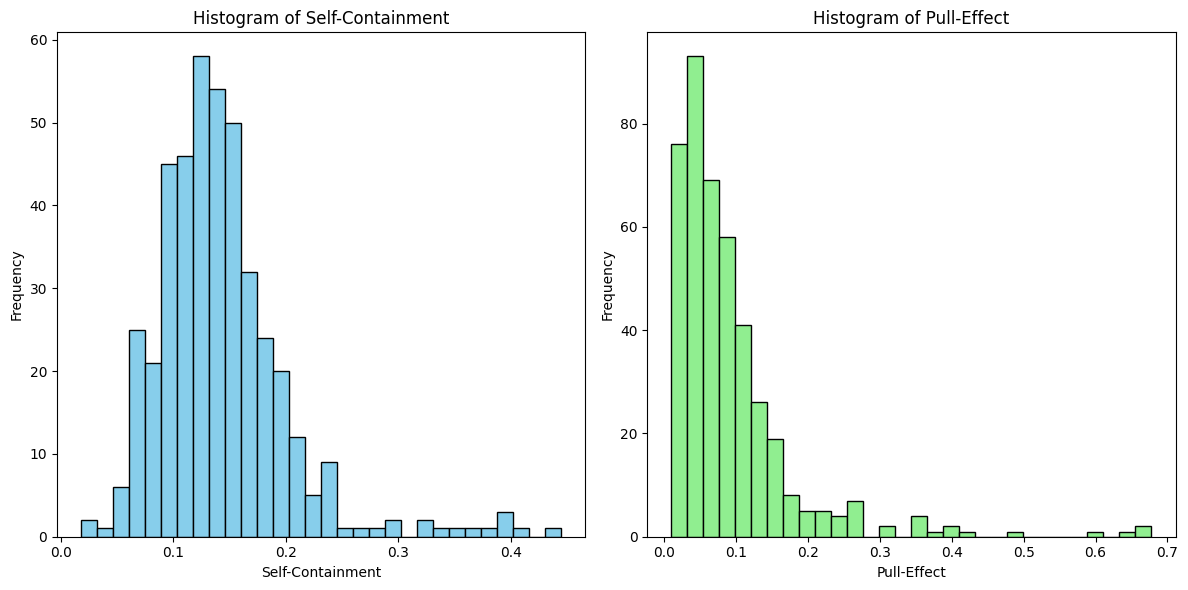

In [ ]:
#@title Distribution of indices
# Plotting the histogram for 'Self-Containment'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(merged_df['Self-Containment'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Self-Containment')
plt.xlabel('Self-Containment')
plt.ylabel('Frequency')

# Plotting the histogram for 'Pull-Effect'
plt.subplot(1, 2, 2)
plt.hist(merged_df['Pull-Effect'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Histogram of Pull-Effect')
plt.xlabel('Pull-Effect')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<ipython-input-45-6214a9869908>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df['Self-Containment'], shade=True, color='skyblue')
<ipython-input-45-6214a9869908>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df['Pull-Effect'], shade=True, color='lightgreen')


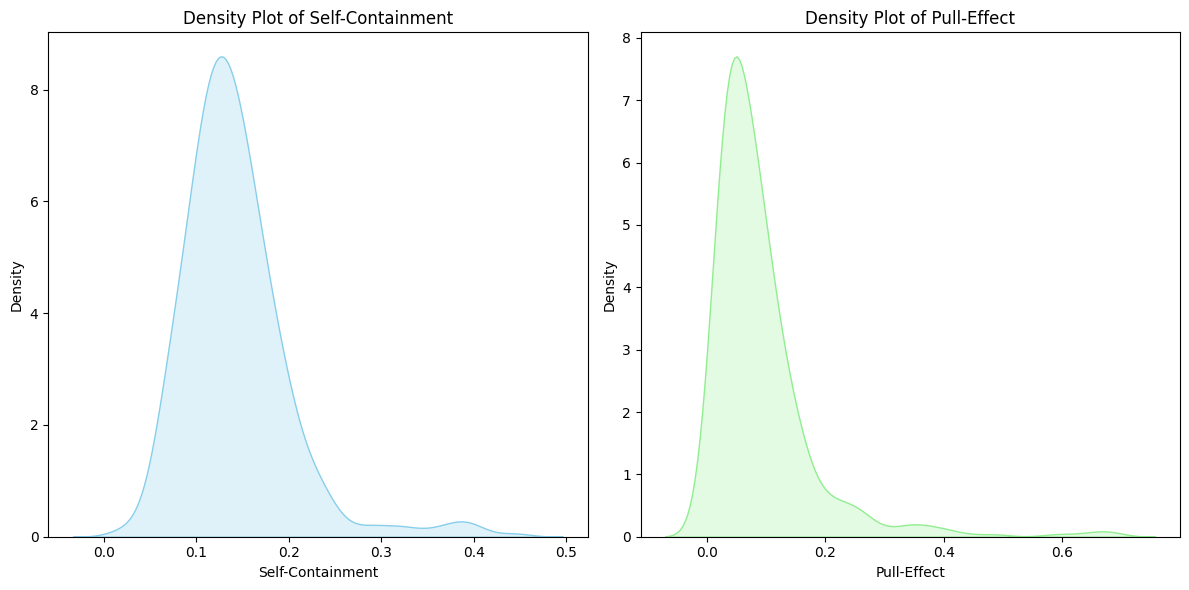

In [ ]:
# Plotting the density plot for 'Self-Containment'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(merged_df['Self-Containment'], shade=True, color='skyblue')
plt.title('Density Plot of Self-Containment')
plt.xlabel('Self-Containment')
plt.ylabel('Density')

# Plotting the density plot for 'Pull-Effect'
plt.subplot(1, 2, 2)
sns.kdeplot(merged_df['Pull-Effect'], shade=True, color='lightgreen')
plt.title('Density Plot of Pull-Effect')
plt.xlabel('Pull-Effect')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

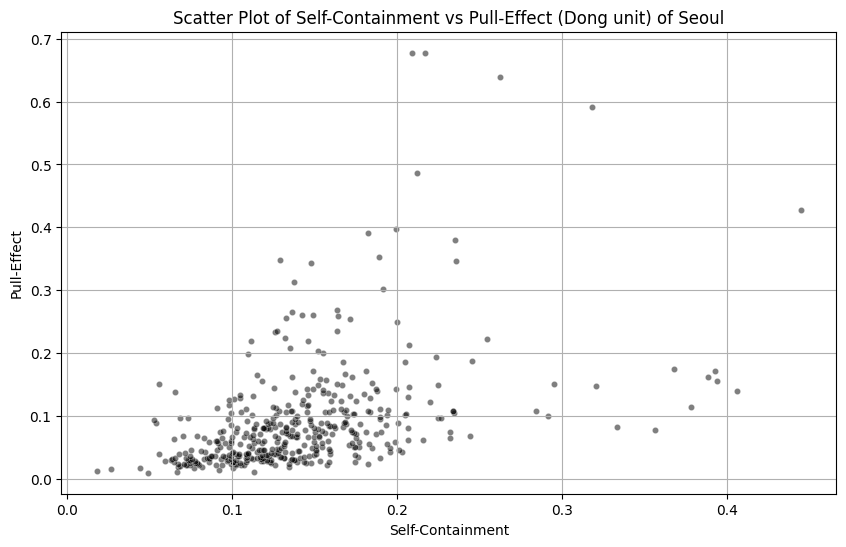

In [ ]:
#@title Scatter plot btw Pull & SC
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Self-Containment', y='Pull-Effect', color='black', alpha=0.5, s=20)
plt.title('Scatter Plot of Self-Containment vs Pull-Effect (Dong unit) of Seoul')
plt.xlabel('Self-Containment')
plt.ylabel('Pull-Effect')
#plt.ylim(0, 60)  # Set y-axis range from 0 to 60
plt.grid(True)
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['Self-Containment'], merged_df['Pull-Effect'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: 0.45
P-value: 0.000


In [ ]:
#@title Pull effect Sort and create inv_rank var
# sort pull-effect in ascending order
merged_df = merged_df.sort_values(by='Pull-Effect', ascending=True)
# create the 'inv_rank' column
merged_df['inv_rank'] = range(1, len(merged_df) + 1)
merged_df.head()

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM,full_dong_name,gu,...,HH,regist_pop,regist_pop_per_HH,elderly_over_65,AREA_km2,pop_density,월_평균_소득_금액,지출_총금액,_merge,inv_rank
14,11110690,0.049283,0.009467,서울특별시 종로구 창신3동,서울특별시 종로구,서울특별시,종로구,창신3동,종로구창신3동,종로구,...,2776.0,6590.0,2.32,1277.0,0.23,28652.173913,3006052.0,3.720450e+08,both,1
320,11620545,0.066493,0.010769,서울특별시 관악구 청림동,서울특별시 관악구,서울특별시,관악구,청림동,관악구청림동,관악구,...,6454.0,15025.0,2.31,2882.0,0.72,20868.055556,3682775.0,1.301897e+09,both,2
334,11620715,0.113486,0.011051,서울특별시 관악구 난향동,서울특별시 관악구,서울특별시,관악구,난향동,관악구난향동,관악구,...,6176.0,14997.0,2.41,2873.0,0.80,18746.250000,3262195.0,7.672670e+08,both,3
345,11650550,0.017877,0.012161,서울특별시 서초구 반포본동,서울특별시 서초구,서울특별시,서초구,반포본동,서초구반포본동,서초구,...,132.0,283.0,2.02,42.0,1.01,280.198020,5583021.0,5.645870e+08,both,4
13,11110680,0.092038,0.013850,서울특별시 종로구 창신2동,서울특별시 종로구,서울특별시,종로구,창신2동,종로구창신2동,종로구,...,4006.0,8760.0,1.91,1888.0,0.26,33692.307692,2112817.0,1.084105e+09,both,5


In [ ]:
#@title Sort SC and create inv_rank_SC
merged_df = merged_df.sort_values(by='Self-Containment', ascending=True)
# create the 'inv_rank_SC' column
merged_df['inv_rank_SC'] = range(1, len(merged_df) + 1)
merged_df.head()

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM,full_dong_name,gu,...,pop_day,pop_even,pop_night,_merge,log_All_pop,log_pop_day,log_pop_even,log_pop_night,log_regist_pop,inv_rank_SC
3,11650550,0.017877,0.012161,서울특별시 서초구 반포본동,서울특별시 서초구,서울특별시,서초구,반포본동,서초구반포본동,서초구,...,5273.035055,4097.511759,2311.827609,both,8.373899,8.570361,8.318135,7.745794,5.645447,1
5,11470610,0.026442,0.014803,서울특별시 양천구 신월6동,서울특별시 양천구,서울특별시,양천구,신월6동,양천구신월6동,양천구,...,4048.695960,4451.074735,3991.990865,both,8.326120,8.306150,8.400901,8.292045,9.542087,2
7,11200720,0.044332,0.016985,서울특별시 성동구 송정동,서울특별시 성동구,서울특별시,성동구,송정동,성동구송정동,성동구,...,9596.104728,9015.284475,10450.913211,both,9.190019,9.169113,9.106677,9.254445,9.249369,3
0,11110690,0.049283,0.009467,서울특별시 종로구 창신3동,서울특별시 종로구,서울특별시,종로구,창신3동,종로구창신3동,종로구,...,3796.559940,4956.808874,6139.366498,both,8.494002,8.241851,8.508517,8.722477,8.793309,4
285,11440610,0.052713,0.092949,서울특별시 마포구 염리동,서울특별시 마포구,서울특별시,마포구,염리동,마포구염리동,마포구,...,17539.289293,17684.827481,17958.679595,both,9.781475,9.772199,9.780462,9.795829,9.781037,5


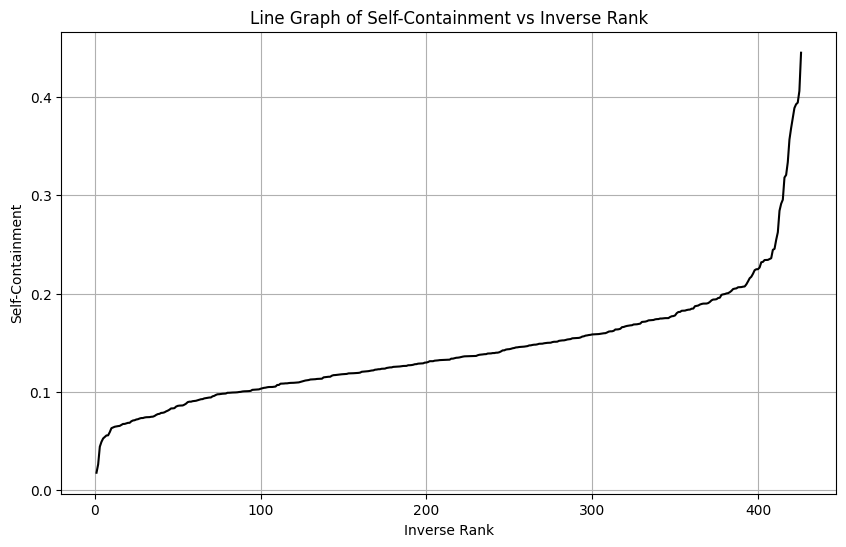

In [ ]:
#@title Scaling Graph of SC
# draw the line graph having y-axis as Self-Containment
# Plotting the line graph with adjusted marker size and color
plt.figure(figsize=(10, 6))
plt.plot(
    merged_df['inv_rank_SC'],
    merged_df['Self-Containment'],
    #marker='o',
    linestyle='-',
    color='k',
    markerfacecolor='black',
    #markeredgecolor='black',
    markersize=1
)
plt.title('Line Graph of Self-Containment vs Inverse Rank')
plt.xlabel('Inverse Rank')
plt.ylabel('Self-Containment')
plt.grid(True)
plt.show()

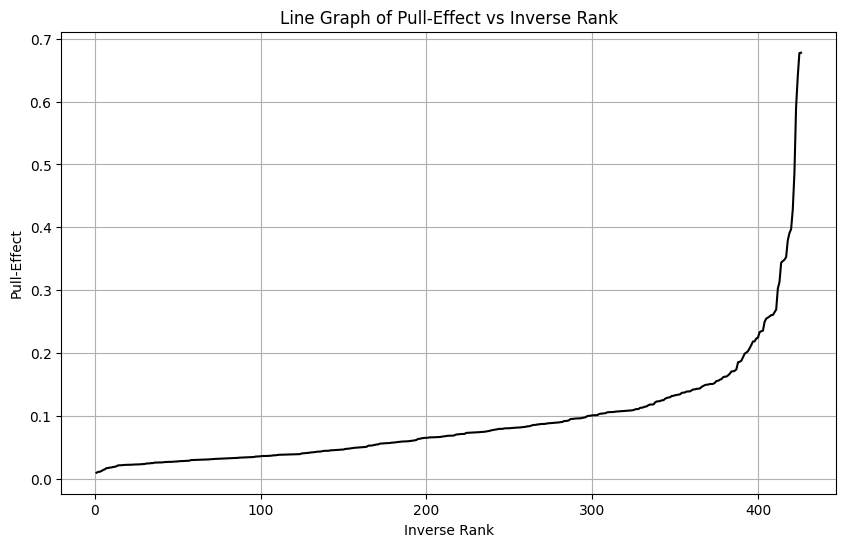

In [ ]:
#@title Scaling graph of PE
# draw the line graph having y-axis as Pull-Effect
# Plotting the line graph with adjusted marker size and color
plt.figure(figsize=(10, 6))
plt.plot(
    merged_df['inv_rank'],
    merged_df['Pull-Effect'],
    #marker='o',
    linestyle='-',
    color='k',
    markerfacecolor='black',
    #markeredgecolor='black',
    markersize=1
)
plt.title('Line Graph of Pull-Effect vs Inverse Rank')
plt.xlabel('Inverse Rank')
plt.ylabel('Pull-Effect')
plt.grid(True)
plt.show()

In [ ]:
# OLS Regression
merged_df.loc[:, 'log_inv_rank'] = np.log(merged_df['inv_rank'])
merged_df.loc[:, 'log_Pull_Effect'] = np.log(merged_df['Pull-Effect'])

X = sm.add_constant(merged_df['log_inv_rank'])
y = merged_df['log_Pull_Effect']

model = sm.OLS(y, X)
results = model.fit()

merged_df.loc[:, 'residuals'] = results.resid
merged_df.loc[:, 'predicted'] = results.predict(X)

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     1393.
Date:                Fri, 25 Oct 2024   Prob (F-statistic):          4.71e-136
Time:                        08:08:40   Log-Likelihood:                -175.49
No. Observations:                 426   AIC:                             355.0
Df Residuals:                     424   BIC:                             363.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -6.1493      0.094    -65.334   

In [ ]:
merged_df.columns

Index(['O_ADMDONG_CD', 'Self-Containment', 'Pull-Effect', 'FULL_NM',
       'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM', 'full_dong_name', 'gu',
       'dong', 'dong_cd', 'HH', 'regist_pop', 'regist_pop_per_HH',
       'elderly_over_65', 'AREA_km2', 'pop_density', 'Average income',
       'Total Spending', 'inv_rank', 'log_inv_rank', 'log_Pull_Effect',
       'residuals', 'predicted', 'All_pop', 'pop_day', 'pop_even', 'pop_night',
       '_merge', 'log_All_pop', 'log_pop_day', 'log_pop_even', 'log_pop_night',
       'log_regist_pop', 'inv_rank_SC'],
      dtype='object')

In [ ]:
#OLS Regression for Self-containment
merged_df.loc[:, 'log_inv_rank_SC'] = np.log(merged_df['inv_rank_SC'])
merged_df.loc[:, 'log_Self-Containment'] = np.log(merged_df['Self-Containment'])

X = sm.add_constant(merged_df['log_inv_rank_SC'])
y = merged_df['log_Self-Containment']

model = sm.OLS(y, X)
results = model.fit()

merged_df.loc[:, 'residuals'] = results.resid
merged_df.loc[:, 'predicted'] = results.predict(X)
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Self-Containment   R-squared:                       0.847
Model:                              OLS   Adj. R-squared:                  0.847
Method:                   Least Squares   F-statistic:                     2353.
Date:                  Fri, 25 Oct 2024   Prob (F-statistic):          3.97e-175
Time:                          08:19:01   Log-Likelihood:                 199.55
No. Observations:                   426   AIC:                            -395.1
Df Residuals:                       424   BIC:                            -387.0
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.

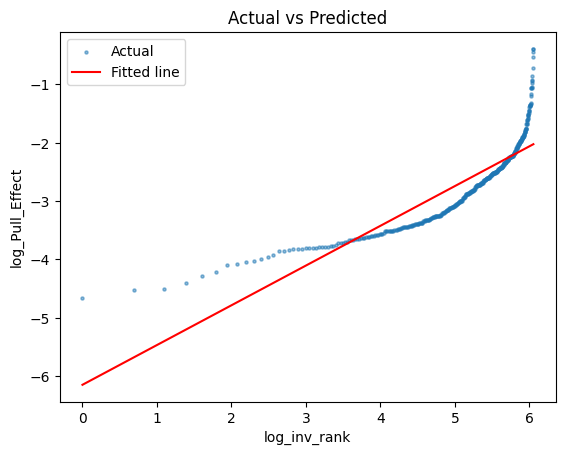

In [ ]:
# line fit plot with rank and Pull-Effect
plt.scatter(merged_df['log_inv_rank'], merged_df['log_Pull_Effect'], s=5, alpha=0.5, label='Actual')
plt.plot(merged_df['log_inv_rank'], merged_df['predicted'], color='red', label='Fitted line')
plt.xlabel('log_inv_rank')
plt.ylabel('log_Pull_Effect')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

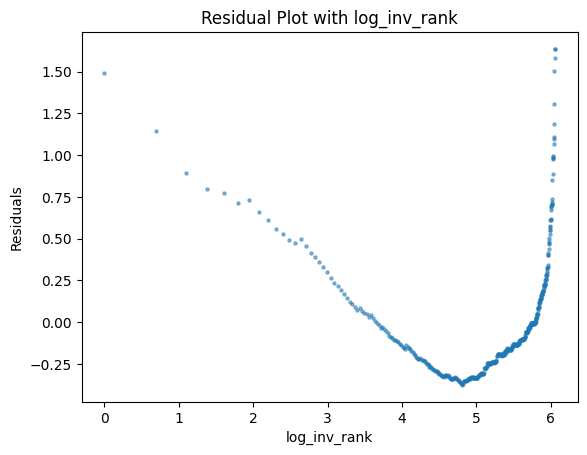

In [ ]:
# Residual plot with rank and residuals
plt.scatter(merged_df['log_inv_rank'], merged_df['residuals'], s=5, alpha=0.5)
plt.xlabel('log_inv_rank')
plt.ylabel('Residuals')
plt.title('Residual Plot with log_inv_rank')
plt.show()

In [ ]:
merged_df.columns

Index(['O_ADMDONG_CD', 'Self-Containment', 'Pull-Effect', 'FULL_NM',
       'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM', 'full_dong_name', 'gu',
       'dong', 'dong_cd', 'HH', 'regist_pop', 'regist_pop_per_HH',
       'elderly_over_65', 'AREA_km2', 'pop_density', '월_평균_소득_금액', '지출_총금액',
       '_merge', 'inv_rank', 'log_inv_rank', 'log_Pull_Effect', 'residuals',
       'predicted'],
      dtype='object')

In [ ]:
merged_df.rename(columns={'월_평균_소득_금액': 'Average income', '지출_총금액': 'Total Spending'}, inplace=True)

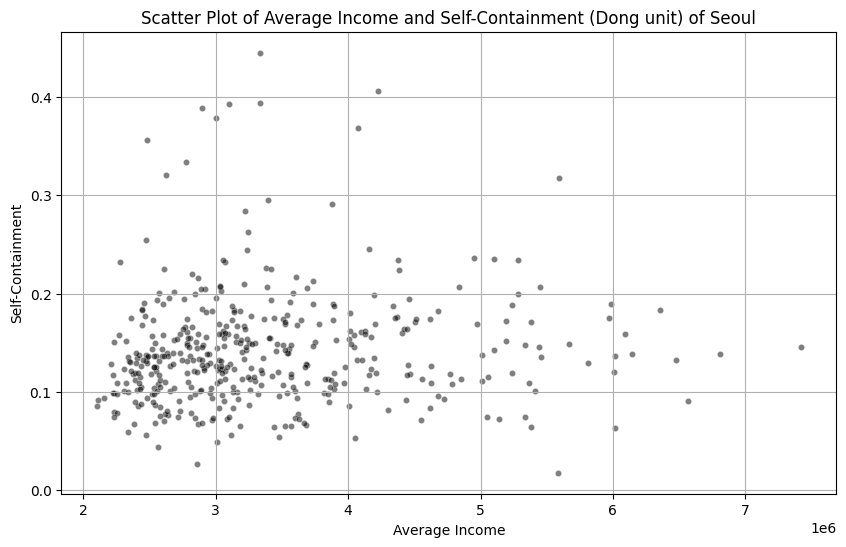

In [ ]:
# Income Level and Self containment
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Average income', y='Self-Containment', color='black', alpha=0.5, s=20)
plt.title('Scatter Plot of Average Income and Self-Containment (Dong unit) of Seoul')
plt.xlabel('Average Income')
plt.ylabel('Self-Containment')
plt.grid(True)
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['Average income'], merged_df['Self-Containment'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: 0.08
P-value: 0.111


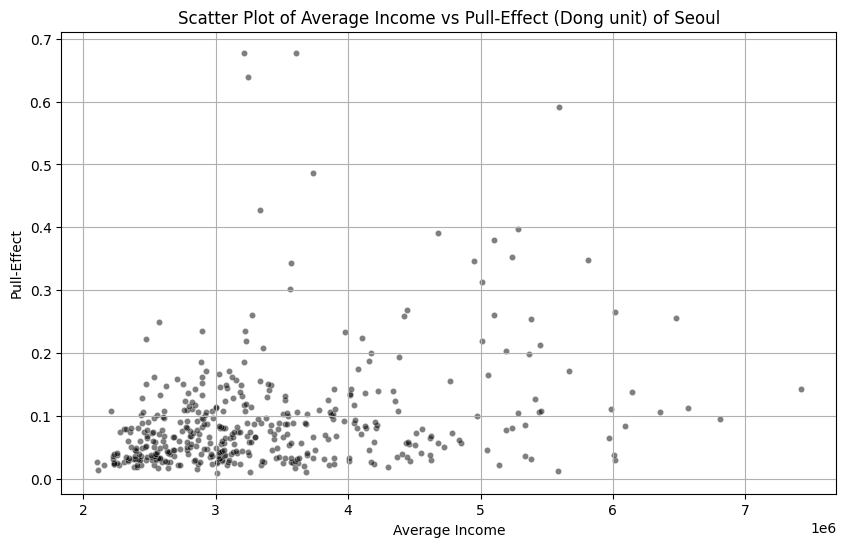

In [ ]:
# Income Level and Pull-effect
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Average income', y='Pull-Effect', color='black', alpha=0.5, s=20)
plt.title('Scatter Plot of Average Income vs Pull-Effect (Dong unit) of Seoul')
plt.xlabel('Average Income')
plt.ylabel('Pull-Effect')
plt.grid(True)
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['Average income'], merged_df['Pull-Effect'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: 0.30
P-value: 0.000


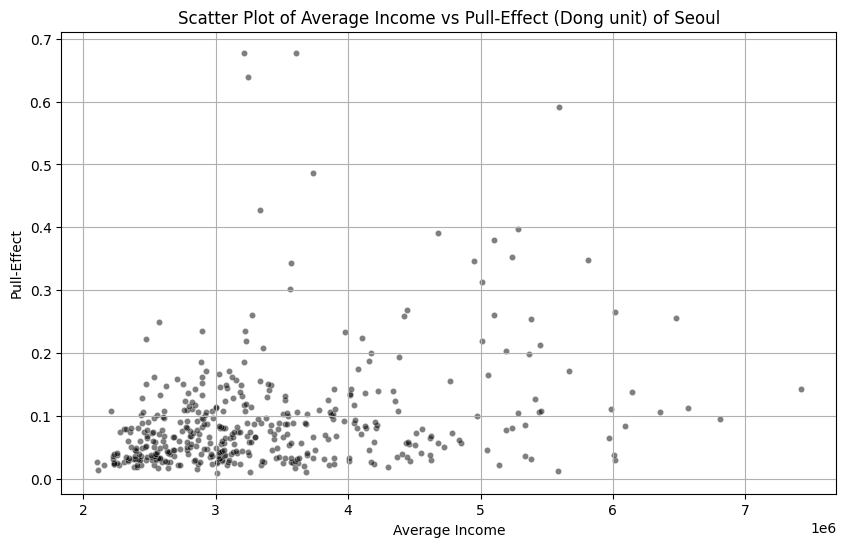

In [ ]:
# Income Level and Pull-effect
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df.loc[merged_df['Pull-Effect']<25,:], x='Average income', y='Pull-Effect', color='black', alpha=0.5, s=20)
plt.title('Scatter Plot of Average Income vs Pull-Effect (Dong unit) of Seoul')
plt.xlabel('Average Income')
plt.ylabel('Pull-Effect')
plt.grid(True)
plt.show()

In [ ]:
merged_df.columns

Index(['O_ADMDONG_CD', 'Self-Containment', 'Pull-Effect', 'FULL_NM',
       'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM', 'full_dong_name', 'gu',
       'dong', 'dong_cd', 'HH', 'regist_pop', 'regist_pop_per_HH',
       'elderly_over_65', 'AREA_km2', 'pop_density', 'Average income',
       'Total Spending', '_merge', 'inv_rank', 'log_inv_rank',
       'log_Pull_Effect', 'residuals', 'predicted'],
      dtype='object')

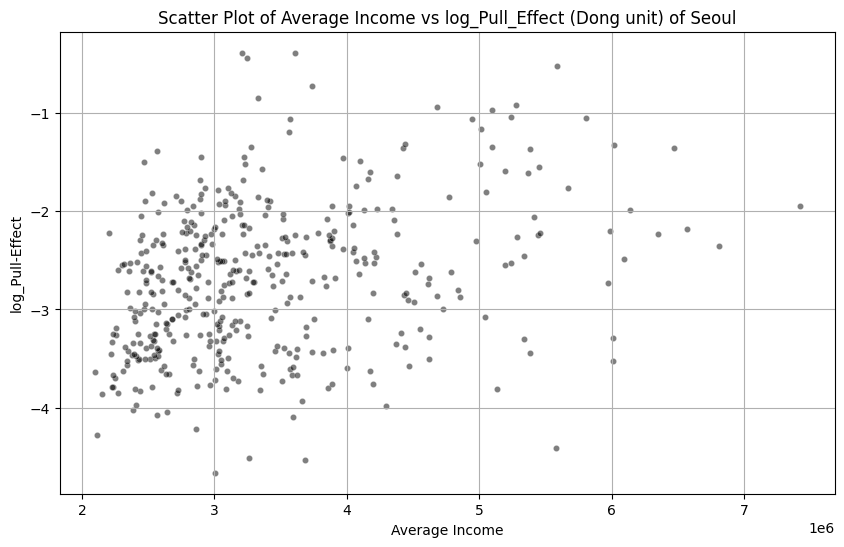

In [ ]:
# Income Level and Log of Pull-effect
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Average income', y='log_Pull_Effect', color='black', alpha=0.5, s=20)
plt.title('Scatter Plot of Average Income vs log_Pull_Effect (Dong unit) of Seoul')
plt.xlabel('Average Income')
plt.ylabel('log_Pull-Effect')
plt.grid(True)
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['Average income'], merged_df['log_Pull_Effect'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: 0.32
P-value: 0.000


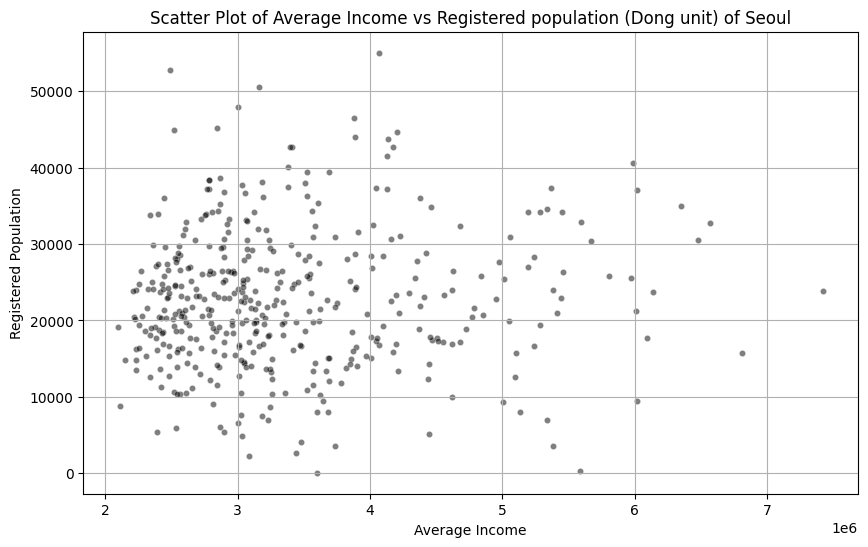

In [ ]:
# Income Level and population
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Average income', y='regist_pop', color='black', alpha=0.5, s=20)
plt.title('Scatter Plot of Average Income vs Registered population (Dong unit) of Seoul')
plt.xlabel('Average Income')
plt.ylabel('Registered Population')
plt.grid(True)
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['Average income'], merged_df['regist_pop'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: 0.06
P-value: 0.193


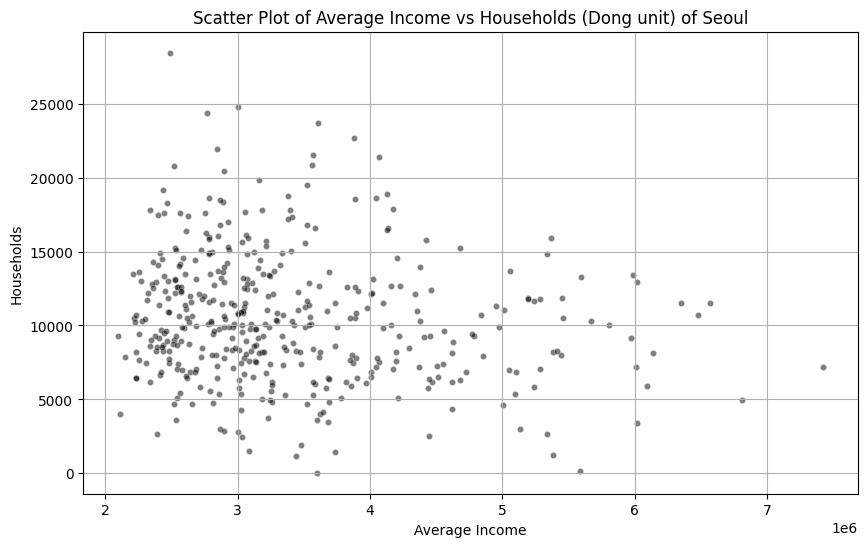

In [ ]:
# Income Level and households
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Average income', y='HH', color='black', alpha=0.5, s=20)
plt.title('Scatter Plot of Average Income vs Households (Dong unit) of Seoul')
plt.xlabel('Average Income')
plt.ylabel('Households')
plt.grid(True)
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['Average income'], merged_df['HH'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: -0.16
P-value: 0.001


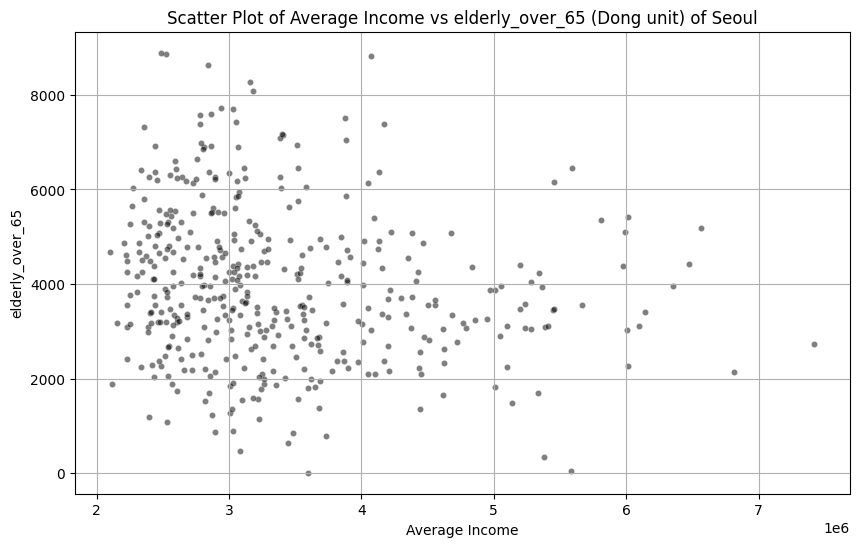

In [ ]:
# Income Level and elderly_over_65
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Average income', y='elderly_over_65', color='black', alpha=0.5, s=20)
plt.title('Scatter Plot of Average Income vs elderly_over_65 (Dong unit) of Seoul')
plt.xlabel('Average Income')
plt.ylabel('elderly_over_65')
plt.grid(True)
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['Average income'], merged_df['elderly_over_65'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: -0.17
P-value: 0.000


In [ ]:
merged_df.columns

Index(['O_ADMDONG_CD', 'Self-Containment', 'Pull-Effect', 'FULL_NM',
       'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM', 'full_dong_name', 'gu',
       'dong', 'dong_cd', 'HH', 'regist_pop', 'regist_pop_per_HH',
       'elderly_over_65', 'AREA_km2', 'pop_density', 'Average income',
       'Total Spending', '_merge', 'inv_rank', 'log_inv_rank',
       'log_Pull_Effect', 'residuals', 'predicted'],
      dtype='object')

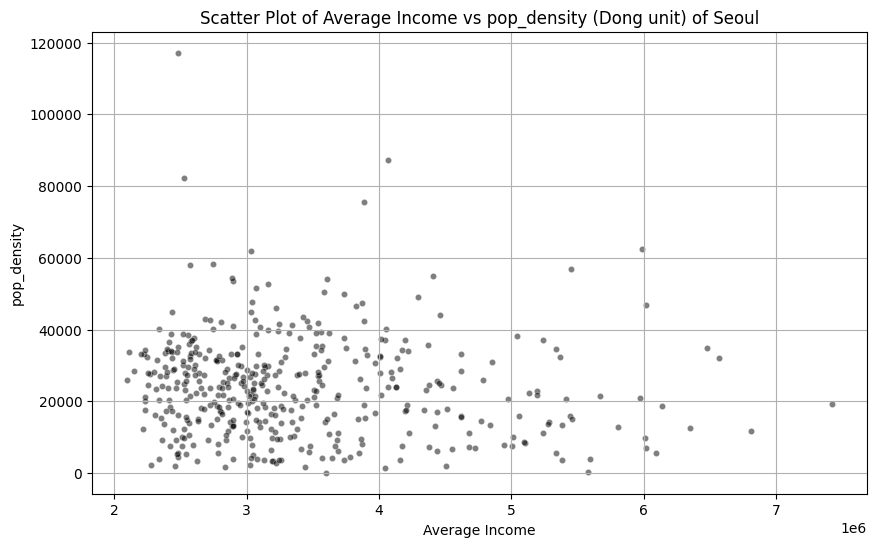

In [ ]:
# Income Level and pop_density
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Average income', y='pop_density', color='black', alpha=0.5, s=20)
plt.title('Scatter Plot of Average Income vs pop_density (Dong unit) of Seoul')
plt.xlabel('Average Income')
plt.ylabel('pop_density')
plt.grid(True)
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['Average income'], merged_df['pop_density'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: -0.09
P-value: 0.062


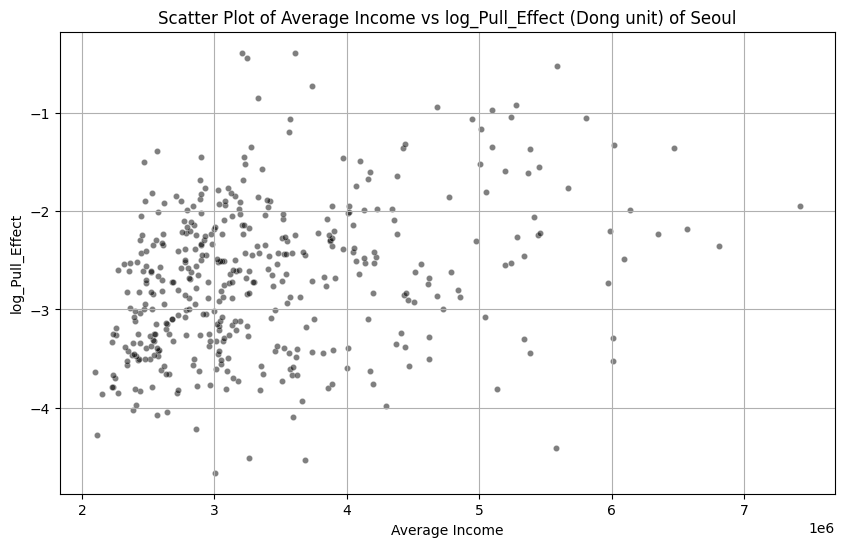

In [ ]:
# Income Level and log_Pull_Effect
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data= merged_df_Seoul, x='Average income', y='log_Pull_Effect', color='black', alpha=0.5, s=20)
plt.title('Scatter Plot of Average Income vs log_Pull_Effect (Dong unit) of Seoul')
plt.xlabel('Average Income')
plt.ylabel('log_Pull_Effect')
plt.grid(True)
plt.show()

In [ ]:
correlation = merged_df_Seoul['Average income'].corr(merged_df_Seoul['log_Pull_Effect'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: 0.32
P-value: 0.062


In [ ]:
# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['Average income'], merged_df['pop_density'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: -0.09
P-value: 0.062


In [ ]:
merged_df.columns

Index(['O_ADMDONG_CD', 'Self-Containment', 'Pull-Effect', 'FULL_NM',
       'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM', 'full_dong_name', 'gu',
       'dong', 'dong_cd', 'HH', 'regist_pop', 'regist_pop_per_HH',
       'elderly_over_65', 'AREA_km2', 'pop_density', 'Average income',
       'Total Spending', '_merge', 'inv_rank', 'log_inv_rank',
       'log_Pull_Effect', 'residuals', 'predicted'],
      dtype='object')

In [ ]:
# Display descriptive statistics of the 'Pull-Effect' column
pull_effect_stats = merged_df['Pull-Effect'].describe()

# Print the descriptive statistics
print(pull_effect_stats)

count    426.000000
mean       0.091374
std        0.089195
min        0.009467
25%        0.036866
50%        0.068332
75%        0.107672
max        0.677788
Name: Pull-Effect, dtype: float64


In [ ]:
# filtering pull-effect higher than 15
highpullgroup = merged_df[merged_df['Pull-Effect'] >= 0.5]
highpullgroup.loc[:, ['full_dong_name','regist_pop', 'HH', 'regist_pop_per_HH', 'elderly_over_65', 'pop_density', 'Average income']]

,full_dong_name,regist_pop,HH,regist_pop_per_HH,elderly_over_65,pop_density,Average income
288,영등포구여의동,32869.0,13307.0,2.44,6448.0,3912.976190,5590853.0
8,종로구종로1.2.3.4가동,8711.0,4947.0,1.36,1790.0,3706.808511,3245251.0
214,마포구서교동,26653.0,15385.0,1.59,3381.0,16153.333333,3212258.0
368,강남구역삼1동,35409.0,23676.0,1.45,3721.0,15067.659574,3607265.0


In [ ]:
# Get summary statistics for the specified columns
summary_statistics = merged_df.loc[:,['regist_pop', 'HH', 'regist_pop_per_HH', 'elderly_over_65', 'pop_density', 'Average income']].describe()
# Round the summary statistics for the 'Average income' column to the nearest integer
summary_statistics['Average income'] = summary_statistics['Average income'].round().astype(int)

In [ ]:
# Round the summary statistics for the specified columns to one decimal place
columns_to_round = ['regist_pop', 'HH', 'regist_pop_per_HH', 'elderly_over_65', 'pop_density']
summary_statistics[columns_to_round] = summary_statistics[columns_to_round].round(1)

In [ ]:
summary_statistics

,regist_pop,HH,regist_pop_per_HH,elderly_over_65,pop_density,Average income
count,426.0,426.0,426.0,426.0,426.0,426
mean,22694.9,10477.4,2.1,3969.4,23866.3,3389964
std,9045.7,4345.6,0.4,1620.4,14116.0,954113
min,74.0,40.0,1.2,11.0,72.5,2099146
25%,16724.2,7496.8,1.9,2884.5,14119.9,2682646
50%,21932.0,10073.5,2.1,3763.5,23256.8,3117272
75%,27945.5,12953.8,2.3,4920.0,32144.4,3855699
max,55043.0,28449.0,3.3,8890.0,117177.8,7421305


In [ ]:
summary_high = highpullgroup.loc[:, ['full_dong_name','regist_pop', 'HH', 'regist_pop_per_HH', 'elderly_over_65', 'pop_density', 'Average income']].describe()
summary_high['Average income'] = summary_high['Average income'].round().astype(int)
summary_high[columns_to_round] = summary_high[columns_to_round].round(1)
summary_high

,regist_pop,HH,regist_pop_per_HH,elderly_over_65,pop_density,Average income
count,4.0,4.0,4.0,4.0,4.0,4
mean,25910.5,14328.8,1.7,3835.0,9710.2,3913907
std,12041.8,7693.0,0.5,1934.7,6828.0,1132194
min,8711.0,4947.0,1.4,1790.0,3706.8,3212258
25%,22167.5,11217.0,1.4,2983.2,3861.4,3237003
50%,29761.0,14346.0,1.5,3551.0,9490.3,3426258
75%,33504.0,17457.8,1.8,4402.8,15339.1,4103162
max,35409.0,23676.0,2.4,6448.0,16153.3,5590853


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   O_ADMDONG_CD       426 non-null    int64   
 1   Self-Containment   426 non-null    float64 
 2   Pull-Effect        426 non-null    float64 
 3   FULL_NM            426 non-null    object  
 4   full_gu_name       426 non-null    object  
 5   SIDO_NM            426 non-null    object  
 6   SGG_NM             426 non-null    object  
 7   ADMI_NM            426 non-null    object  
 8   full_dong_name     426 non-null    object  
 9   gu                 426 non-null    object  
 10  dong               426 non-null    object  
 11  dong_cd            426 non-null    float64 
 12  HH                 426 non-null    float64 
 13  regist_pop         426 non-null    float64 
 14  regist_pop_per_HH  426 non-null    float64 
 15  elderly_over_65    426 non-null    float64 
 16  AREA_km2

### De Facto Population Data Preprocessing

In [ ]:
pop = pd.read_csv('/content/drive/MyDrive/FMC_Data/LOCAL_PEOPLE_DONG_202303/LOCAL_PEOPLE_DONG_202303.csv', engine='python')
pop.columns = ['hour_category', 'ADMDONG_CD', 'All_pop', 'M0_9', 'M10_14', 'M15_19', 'M20_24', 'M25_29',
              'M30_34', 'M35_39', 'M40_44', 'M45_49', 'M50_54', 'M55_59', 'M60_64', 'M65_69', 'M70_up', 'F0_9', 'F10_14', 'F15_19', 'F20_24', 'F25_29',
              'F30_34', 'F35_39', 'F40_44', 'F45_49', 'F50_54', 'F55_59', 'F60_64', 'F65_69', 'F70_up', 'novalues']

In [ ]:
pop.head()

,hour_category,ADMDONG_CD,All_pop,M0_9,M10_14,M15_19,M20_24,M25_29,M30_34,M35_39,...,F30_34,F35_39,F40_44,F45_49,F50_54,F55_59,F60_64,F65_69,F70_up,novalues
20230301,0,11500605,12152.9760,314.2590,99.2728,147.1853,125.0909,326.6752,600.0004,840.6125,...,761.3044,767.4585,391.5118,392.7704,377.4368,484.7090,509.1466,419.8514,1164.6325,NaN
20230301,0,11530750,26973.1386,1162.3654,452.8302,684.9993,578.3383,754.6888,901.7400,1170.0395,...,1137.1146,1210.0504,964.0278,1156.5304,962.3229,1291.0357,1142.7477,859.0726,2118.4307,NaN
20230301,0,11140650,9021.9829,307.1753,142.0813,156.1640,228.6131,390.8249,397.4347,403.5795,...,401.4260,437.3798,358.1555,333.1254,313.1381,425.0811,326.8493,198.8057,580.5874,NaN
20230301,0,11200645,26758.6325,1678.3430,465.1377,402.1320,400.6940,536.1799,709.9476,1474.4158,...,1053.7237,1718.0640,1432.6263,1255.1849,963.4359,1030.2344,956.1777,808.9140,1691.4118,NaN
20230301,0,11470610,4062.9669,132.5704,86.6805,108.5833,83.5500,119.4311,149.3410,205.6582,...,148.7245,169.2240,183.6700,162.8845,144.1637,178.7602,172.3166,128.2686,309.6982,NaN


In [ ]:
# pop 10 am to 5 pm
pop_day = pop[(pop['hour_category'] >= 10) & (pop['hour_category'] <= 17)]

# pop 7 pm (19) to 11 pm (23)
pop_even = pop[(pop['hour_category'] >= 19) & (pop['hour_category'] <= 23)]

# pop 0 am to 5 am
pop_night = pop[(pop['hour_category'] >= 0) & (pop['hour_category'] <= 5)]

In [ ]:
# Calculate mean of 'All_pop' for each subgroup aggregated by 'ADMDONG_CD'
mean_pop_day = pop_day.groupby('ADMDONG_CD')['All_pop'].mean().reset_index().rename(columns={'All_pop': 'pop_day'})
mean_pop_even = pop_even.groupby('ADMDONG_CD')['All_pop'].mean().reset_index().rename(columns={'All_pop': 'pop_even'})
mean_pop_night = pop_night.groupby('ADMDONG_CD')['All_pop'].mean().reset_index().rename(columns={'All_pop': 'pop_night'})

In [ ]:
num_unique_values = pop.ADMDONG_CD.nunique()
num_unique_values

424

In [ ]:
# Calculate the overall mean 'All_pop' aggregated by 'ADMDONG_CD'
df_avg_pop = pop.groupby('ADMDONG_CD')['All_pop'].mean().reset_index()

In [ ]:
# Merge the mean values of each subgroup into df_avg_pop
df_avg_pop = df_avg_pop.merge(mean_pop_day, on='ADMDONG_CD', how='left')
df_avg_pop = df_avg_pop.merge(mean_pop_even, on='ADMDONG_CD', how='left')
df_avg_pop = df_avg_pop.merge(mean_pop_night, on='ADMDONG_CD', how='left')

In [ ]:
df_avg_pop

,ADMDONG_CD,All_pop,pop_day,pop_even,pop_night
0,11110515,18490.636366,22764.928625,15540.243662,15536.578539
1,11110530,25468.544788,38669.909753,19899.427852,12562.808277
2,11110540,5994.128247,8955.262907,4403.752663,3714.633690
3,11110550,14177.413914,14623.881172,13568.003504,14163.015759
4,11110560,17815.873594,16642.971492,18076.485135,19008.752418
...,...,...,...,...,...
419,11740650,23320.440226,21152.246508,24548.487386,25483.540820
420,11740660,27011.381976,25919.255473,28070.301445,28104.395551
421,11740685,55860.206574,53228.513299,57382.971513,58845.395184
422,11740690,5006.747107,4973.399346,4454.051931,4970.659124


In [ ]:
df_avg_pop.columns

Index(['ADMDONG_CD', 'All_pop', 'pop_day', 'pop_even', 'pop_night'], dtype='object')

In [ ]:
merged_df.columns

Index(['Unnamed: 0', 'O_ADMDONG_CD', 'Self-Containment', 'Pull-Effect',
       'FULL_NM', 'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM',
       'full_dong_name', 'gu', 'dong', 'dong_cd', 'HH', 'regist_pop',
       'regist_pop_per_HH', 'elderly_over_65', 'AREA_km2', 'pop_density',
       '월_평균_소득_금액', '지출_총금액', '_merge'],
      dtype='object')

In [ ]:
merged_df = merged_df.drop(columns=['_merge'])

In [ ]:
invest_dong = pd.merge(df_avg_pop, merged_df, left_on = 'ADMDONG_CD', right_on = 'O_ADMDONG_CD', how = 'left', indicator = True)
invest_dong[invest_dong['_merge'] == 'left_only']

,ADMDONG_CD,All_pop,pop_day,pop_even,pop_night,Unnamed: 0,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,...,dong_cd,HH,regist_pop,regist_pop_per_HH,elderly_over_65,AREA_km2,pop_density,월_평균_소득_금액,지출_총금액,_merge
135,11305590,17098.879721,16442.854330,17949.631197,17557.445248,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
136,11305600,12047.590910,10398.439607,11790.192827,14439.618044,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
137,11305606,14390.882043,12376.274836,14964.732553,16717.495797,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
138,11305610,16747.297240,14914.960801,16428.066257,19296.292681,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
139,11305620,17258.013575,15581.994190,18901.431288,18570.040794,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
140,11305630,27883.993451,26890.907624,30918.092982,27410.579467,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
377,11680740,16628.476658,15957.549148,16508.886659,17450.284140,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
407,11740520,40455.392941,36845.739202,42090.911857,43921.979068,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


de facto pop 데이터셋에만 있는 코드: 11305590, 11305600, 11305606, 11305610, 11305620, 11305630, 11680740, 11740520
11305590: 중계4동 (노원구)
11305600: 상계1동 (노원구)
11305606: 상계2동 (노원구)
11305610: 상계3·4동 (노원구)
11305620: 상계5동 (노원구)
11305630: 상계6·7동 (노원구)
11680740: 은평동 (은평구)
11740520: 구의2동 (광진구)

In [ ]:
merged_df = merged_df.drop(columns=['_merge'])

In [ ]:
# merge 'All_pop' of df_avg_pop dataframe
merged_df = pd.merge(merged_df, df_avg_pop, left_on = 'O_ADMDONG_CD', right_on = 'ADMDONG_CD', how = 'left', indicator=True)
merged_df = merged_df.drop(columns=['ADMDONG_CD'])
merged_df.head()

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM,full_dong_name,gu,...,inv_rank,log_inv_rank,log_Pull_Effect,residuals,predicted,All_pop,pop_day,pop_even,pop_night,_merge
0,11110690,0.049283,0.009467,서울특별시 종로구 창신3동,서울특별시 종로구,서울특별시,종로구,창신3동,종로구창신3동,종로구,...,1,0.000000,-4.659897,1.489356,-6.149253,4885.379349,3796.559940,4956.808874,6139.366498,both
1,11620545,0.066493,0.010769,서울특별시 관악구 청림동,서울특별시 관악구,서울특별시,관악구,청림동,관악구청림동,관악구,...,2,0.693147,-4.531060,1.145985,-5.677045,11215.280117,7641.939397,11816.380959,15584.343549,both
2,11620715,0.113486,0.011051,서울특별시 관악구 난향동,서울특별시 관악구,서울특별시,관악구,난향동,관악구난향동,관악구,...,3,1.098612,-4.505189,0.895631,-5.400820,9963.086605,7530.590740,10593.413036,12764.055827,both
3,11650550,0.017877,0.012161,서울특별시 서초구 반포본동,서울특별시 서초구,서울특별시,서초구,반포본동,서초구반포본동,서초구,...,4,1.386294,-4.409493,0.795343,-5.204836,4332.495999,5273.035055,4097.511759,2311.827609,both
4,11110680,0.092038,0.013850,서울특별시 종로구 창신2동,서울특별시 종로구,서울특별시,종로구,창신2동,종로구창신2동,종로구,...,5,1.609438,-4.279499,0.773320,-5.052819,9484.695413,8573.132649,9585.996480,10477.089744,both


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   O_ADMDONG_CD       426 non-null    int64   
 1   Self-Containment   426 non-null    float64 
 2   Pull-Effect        426 non-null    float64 
 3   FULL_NM            426 non-null    object  
 4   full_gu_name       426 non-null    object  
 5   SIDO_NM            426 non-null    object  
 6   SGG_NM             426 non-null    object  
 7   ADMI_NM            426 non-null    object  
 8   full_dong_name     426 non-null    object  
 9   gu                 426 non-null    object  
 10  dong               426 non-null    object  
 11  dong_cd            426 non-null    float64 
 12  HH                 426 non-null    float64 
 13  regist_pop         426 non-null    float64 
 14  regist_pop_per_HH  426 non-null    float64 
 15  elderly_over_65    426 non-null    float64 
 16  AREA_km2

In [ ]:
# Filter rows where the merge indicator indicates the row is only present in df_avg_pop
unmatched_rows = merged_df[merged_df['_merge'] == 'left_only']
unmatched_rows

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM,full_dong_name,gu,...,inv_rank,log_inv_rank,log_Pull_Effect,residuals,predicted,All_pop,pop_day,pop_even,pop_night,_merge
32,11530800,0.144674,0.024365,서울특별시 구로구 항동,서울특별시 구로구,서울특별시,구로구,항동,구로구항동,구로구,...,33,3.496508,-3.714616,0.052631,-3.767247,NaN,NaN,NaN,NaN,left_only
44,11305603,0.100461,0.026754,서울특별시 강북구 번2동,서울특별시 강북구,서울특별시,강북구,번2동,강북구번2동,강북구,...,45,3.806662,-3.621056,-0.065103,-3.555954,NaN,NaN,NaN,NaN,left_only
66,11305608,0.121004,0.030302,서울특별시 강북구 번3동,서울특별시 강북구,서울특별시,강북구,번3동,강북구번3동,강북구,...,67,4.204693,-3.496534,-0.211740,-3.284794,NaN,NaN,NaN,NaN,left_only
75,11305615,0.117365,0.031737,서울특별시 강북구 수유1동,서울특별시 강북구,서울특별시,강북구,수유1동,강북구수유1동,강북구,...,76,4.330733,-3.450272,-0.251343,-3.198929,NaN,NaN,NaN,NaN,left_only
112,11740526,0.109029,0.038172,서울특별시 강동구 상일2동,서울특별시 강동구,서울특별시,강동구,상일2동,강동구상일2동,강동구,...,113,4.727388,-3.265653,-0.336946,-2.928707,NaN,NaN,NaN,NaN,left_only
127,11680675,0.071242,0.040894,서울특별시 강남구 개포3동,서울특별시 강남구,서울특별시,강남구,개포3동,강남구개포3동,강남구,...,128,4.852030,-3.196767,-0.352973,-2.843794,NaN,NaN,NaN,NaN,left_only
154,11305625,0.111876,0.048445,서울특별시 강북구 수유2동,서울특별시 강북구,서울특별시,강북구,수유2동,강북구수유2동,강북구,...,155,5.043425,-3.027324,-0.313918,-2.713405,NaN,NaN,NaN,NaN,left_only
242,11305595,0.123066,0.078457,서울특별시 강북구 번1동,서울특별시 강북구,서울특별시,강북구,번1동,강북구번1동,강북구,...,243,5.493061,-2.545202,-0.138112,-2.407089,NaN,NaN,NaN,NaN,left_only
305,11740525,0.205293,0.103666,서울특별시 강동구 상일1동,서울특별시 강동구,서울특별시,강동구,상일1동,강동구상일1동,강동구,...,306,5.723585,-2.266583,-0.016539,-2.250044,NaN,NaN,NaN,NaN,left_only
321,11305635,0.128275,0.108216,서울특별시 강북구 수유3동,서울특별시 강북구,서울특별시,강북구,수유3동,강북구수유3동,강북구,...,322,5.774552,-2.223627,-0.008304,-2.215323,NaN,NaN,NaN,NaN,left_only


indices 데이터에는 있는데 de facto pop 데이터에는 없는 동: 구로구 항동, 강북구 번1동, 번2동, 번3동, 수유1동, 수유2동, 수유3동, 강동구 상일1동, 상일2동, 강남구 개포3동

In [ ]:
# Transform variables
merged_df.loc[:,'log_regist_pop'] = np.log(merged_df['regist_pop'])
merged_df.loc[:,'log_All_pop'] = np.log(merged_df['All_pop'])
merged_df.loc[:,'log_pop_day'] = np.log(merged_df['pop_day'])
merged_df.loc[:,'log_pop_even'] = np.log(merged_df['pop_even'])
merged_df.loc[:,'log_pop_night'] = np.log(merged_df['pop_night'])

In [ ]:
merged_df.columns

Index(['O_ADMDONG_CD', 'Self-Containment', 'Pull-Effect', 'FULL_NM',
       'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM', 'full_dong_name', 'gu',
       'dong', 'dong_cd', 'HH', 'regist_pop', 'regist_pop_per_HH',
       'elderly_over_65', 'AREA_km2', 'pop_density', 'Average income',
       'Total Spending', 'inv_rank', 'log_inv_rank', 'log_Pull_Effect',
       'residuals', 'predicted', 'All_pop', 'pop_day', 'pop_even', 'pop_night',
       '_merge', 'log_All_pop', 'log_pop_day', 'log_pop_even',
       'log_pop_night'],
      dtype='object')

In [ ]:
merged_df_Seoul = merged_df

In [ ]:
null_all_pop_rows = merged_df_Seoul[merged_df_Seoul['All_pop'].isnull()]
null_all_pop_rows

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM,full_dong_name,gu,...,All_pop,pop_day,pop_even,pop_night,_merge,log_All_pop,log_pop_day,log_pop_even,log_pop_night,log_regist_pop
32,11530800,0.144674,0.024365,서울특별시 구로구 항동,서울특별시 구로구,서울특별시,구로구,항동,구로구항동,구로구,...,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN,NaN,9.715590
44,11305603,0.100461,0.026754,서울특별시 강북구 번2동,서울특별시 강북구,서울특별시,강북구,번2동,강북구번2동,강북구,...,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN,NaN,9.635281
66,11305608,0.121004,0.030302,서울특별시 강북구 번3동,서울특별시 강북구,서울특별시,강북구,번3동,강북구번3동,강북구,...,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN,NaN,9.699840
75,11305615,0.117365,0.031737,서울특별시 강북구 수유1동,서울특별시 강북구,서울특별시,강북구,수유1동,강북구수유1동,강북구,...,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN,NaN,9.927741
112,11740526,0.109029,0.038172,서울특별시 강동구 상일2동,서울특별시 강동구,서울특별시,강동구,상일2동,강동구상일2동,강동구,...,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN,NaN,9.394161
127,11680675,0.071242,0.040894,서울특별시 강남구 개포3동,서울특별시 강남구,서울특별시,강남구,개포3동,강남구개포3동,강남구,...,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN,NaN,9.751850
154,11305625,0.111876,0.048445,서울특별시 강북구 수유2동,서울특별시 강북구,서울특별시,강북구,수유2동,강북구수유2동,강북구,...,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN,NaN,9.951611
242,11305595,0.123066,0.078457,서울특별시 강북구 번1동,서울특별시 강북구,서울특별시,강북구,번1동,강북구번1동,강북구,...,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN,NaN,9.830487
305,11740525,0.205293,0.103666,서울특별시 강동구 상일1동,서울특별시 강동구,서울특별시,강동구,상일1동,강동구상일1동,강동구,...,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN,NaN,10.582409
321,11305635,0.128275,0.108216,서울특별시 강북구 수유3동,서울특별시 강북구,서울특별시,강북구,수유3동,강북구수유3동,강북구,...,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN,NaN,10.080880


In [ ]:
merged_df.to_excel("/content/drive/MyDrive/FMC_Data/matched_Seoul_dong_y_and_Xvariables_with_different time zone de facto populations_24567.xlsx")

### Regression with Card Data

In [10]:
df_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dest                   425 non-null    object 
 1   diff_amt_total_all     425 non-null    int64  
 2   diff_num_total_all     425 non-null    int64  
 3   diff_amt_total_S       425 non-null    int64  
 4   diff_num_total_S       425 non-null    int64  
 5   pop_defacto            423 non-null    float64
 6   ln_pop_defacto         423 non-null    float64
 7   ln_diff_amt_total_all  425 non-null    float64
 8   ln_diff_num_total_all  425 non-null    float64
 9   ln_diff_amt_total_S    425 non-null    float64
 10  ln_diff_num_total_S    425 non-null    float64
 11  CBD1_YBD2_GBD3         425 non-null    int64  
 12  Dummy_CBD123           425 non-null    int64  
 13  Dummy_CBD1only         425 non-null    int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 46.6+ KB


In [26]:
# de facto population 결측치 제외
df_card = df_card.loc[df_card['ln_pop_defacto']!=0]

In [32]:
#@title Regression y=Ln(total value of non-local POS transactions in a dong, amt_NL), x= total de facto pop (All_pop)

# Replace drop any rows containing NaN
df_card = df_card.dropna()

# Add a constant to the independent values
X = sm.add_constant(df_card['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card['ln_diff_amt_total_all'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_diff_amt_total_all   R-squared:                       0.338
Model:                               OLS   Adj. R-squared:                  0.336
Method:                    Least Squares   F-statistic:                     211.2
Date:                   Thu, 19 Dec 2024   Prob (F-statistic):           5.90e-39
Time:                           09:05:43   Log-Likelihood:                -681.69
No. Observations:                    416   AIC:                             1367.
Df Residuals:                        414   BIC:                             1375.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

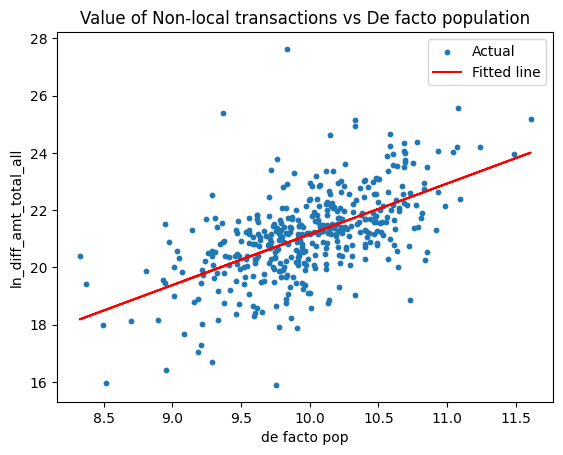

In [34]:
# Calculate predicted values
df_card['predicted'] = results.predict(X)
plt.scatter(df_card['ln_pop_defacto'], df_card['ln_diff_amt_total_all'], s=10, label='Actual')
plt.plot(df_card['ln_pop_defacto'], df_card['predicted'], color='red', label='Fitted line')
plt.xlabel('de facto pop')
plt.ylabel('ln_diff_amt_total_all')
plt.title('Value of Non-local transactions vs De facto population')
plt.legend()
plt.show()

In [35]:
# Replace drop any rows containing NaN
df_card = df_card.dropna()

# Add a constant to the independent values
X = sm.add_constant(df_card['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card['ln_diff_num_total_all'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_diff_num_total_all   R-squared:                       0.333
Model:                               OLS   Adj. R-squared:                  0.331
Method:                    Least Squares   F-statistic:                     206.3
Date:                   Thu, 19 Dec 2024   Prob (F-statistic):           3.05e-38
Time:                           09:07:07   Log-Likelihood:                -639.45
No. Observations:                    416   AIC:                             1283.
Df Residuals:                        414   BIC:                             1291.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

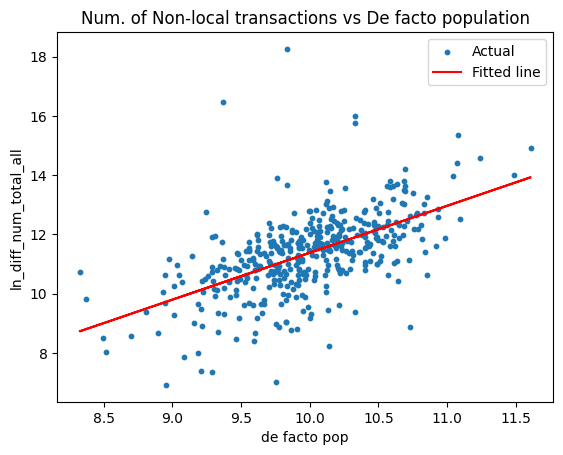

In [36]:
# Calculate predicted values
df_card['predicted'] = results.predict(X)
plt.scatter(df_card['ln_pop_defacto'], df_card['ln_diff_num_total_all'], s=10, label='Actual')
plt.plot(df_card['ln_pop_defacto'], df_card['predicted'], color='red', label='Fitted line')
plt.xlabel('de facto pop')
plt.ylabel('ln_diff_num_total_all')
plt.title('Num. of Non-local transactions vs De facto population')
plt.legend()
plt.show()

In [37]:
# Replace drop any rows containing NaN
df_card = df_card.dropna()
# Add a constant to the independent values
X = sm.add_constant(df_card['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card['ln_diff_amt_total_S'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_diff_amt_total_S   R-squared:                       0.317
Model:                             OLS   Adj. R-squared:                  0.315
Method:                  Least Squares   F-statistic:                     192.1
Date:                 Thu, 19 Dec 2024   Prob (F-statistic):           3.78e-36
Time:                         09:07:33   Log-Likelihood:                -667.00
No. Observations:                  416   AIC:                             1338.
Df Residuals:                      414   BIC:                             1346.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.7092      1.1

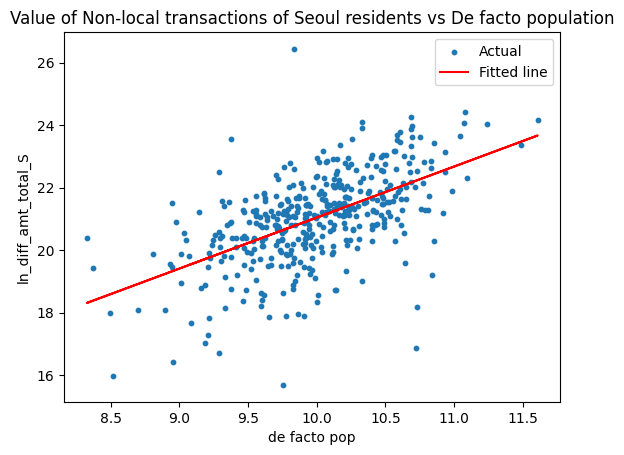

In [38]:
# Calculate predicted values
df_card['predicted'] = results.predict(X)
plt.scatter(df_card['ln_pop_defacto'], df_card['ln_diff_amt_total_S'], s=10, label='Actual')
plt.plot(df_card['ln_pop_defacto'], df_card['predicted'], color='red', label='Fitted line')
plt.xlabel('de facto pop')
plt.ylabel('ln_diff_amt_total_S')
plt.title('Value of Non-local transactions of Seoul residents vs De facto population')
plt.legend()
plt.show()

In [40]:
# Replace drop any rows containing NaN
df_card = df_card.dropna()
# Add a constant to the independent values
X = sm.add_constant(df_card['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card['ln_diff_num_total_S'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_diff_num_total_S   R-squared:                       0.330
Model:                             OLS   Adj. R-squared:                  0.328
Method:                  Least Squares   F-statistic:                     203.7
Date:                 Thu, 19 Dec 2024   Prob (F-statistic):           7.29e-38
Time:                         09:12:19   Log-Likelihood:                -615.66
No. Observations:                  416   AIC:                             1235.
Df Residuals:                      414   BIC:                             1243.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.5958      1.0

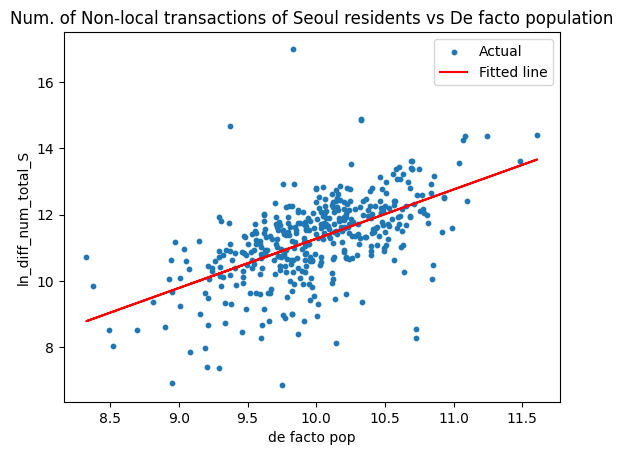

In [41]:
# Calculate predicted values
df_card['predicted'] = results.predict(X)
plt.scatter(df_card['ln_pop_defacto'], df_card['ln_diff_num_total_S'], s=10, label='Actual')
plt.plot(df_card['ln_pop_defacto'], df_card['predicted'], color='red', label='Fitted line')
plt.xlabel('de facto pop')
plt.ylabel('ln_diff_num_total_S')
plt.title('Num. of Non-local transactions of Seoul residents vs De facto population')
plt.legend()
plt.show()

In [42]:
#@title exclude CBD
df_card_ex3CBDs = df_card.loc[df_card['Dummy_CBD123'] == 0]
df_card_ex1CBD = df_card.loc[df_card['Dummy_CBD1only'] == 0]

In [43]:
#@title regression excluding 3CBDs
# Replace drop any rows containing NaN
df_card_ex3CBDs = df_card_ex3CBDs.dropna()

# Add a constant to the independent values
X = sm.add_constant(df_card_ex3CBDs['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card_ex3CBDs['ln_diff_amt_total_all'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_diff_amt_total_all   R-squared:                       0.297
Model:                               OLS   Adj. R-squared:                  0.296
Method:                    Least Squares   F-statistic:                     164.3
Date:                   Thu, 19 Dec 2024   Prob (F-statistic):           1.33e-31
Time:                           09:14:56   Log-Likelihood:                -616.03
No. Observations:                    390   AIC:                             1236.
Df Residuals:                        388   BIC:                             1244.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

In [44]:
# Replace drop any rows containing NaN
df_card_ex3CBDs = df_card_ex3CBDs.dropna()

# Add a constant to the independent values
X = sm.add_constant(df_card_ex3CBDs['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card_ex3CBDs['ln_diff_num_total_all'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_diff_num_total_all   R-squared:                       0.304
Model:                               OLS   Adj. R-squared:                  0.302
Method:                    Least Squares   F-statistic:                     169.6
Date:                   Thu, 19 Dec 2024   Prob (F-statistic):           2.08e-32
Time:                           09:15:06   Log-Likelihood:                -572.75
No. Observations:                    390   AIC:                             1149.
Df Residuals:                        388   BIC:                             1157.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

In [45]:
# Replace drop any rows containing NaN
df_card_ex3CBDs = df_card_ex3CBDs.dropna()
# Add a constant to the independent values
X = sm.add_constant(df_card_ex3CBDs['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card_ex3CBDs['ln_diff_amt_total_S'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_diff_amt_total_S   R-squared:                       0.276
Model:                             OLS   Adj. R-squared:                  0.275
Method:                  Least Squares   F-statistic:                     148.3
Date:                 Thu, 19 Dec 2024   Prob (F-statistic):           4.12e-29
Time:                         09:15:09   Log-Likelihood:                -616.35
No. Observations:                  390   AIC:                             1237.
Df Residuals:                      388   BIC:                             1245.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.8092      1.2

In [46]:
# Replace drop any rows containing NaN
df_card_ex3CBDs = df_card_ex3CBDs.dropna()
# Add a constant to the independent values
X = sm.add_constant(df_card_ex3CBDs['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card_ex3CBDs['ln_diff_num_total_S'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_diff_num_total_S   R-squared:                       0.297
Model:                             OLS   Adj. R-squared:                  0.295
Method:                  Least Squares   F-statistic:                     164.1
Date:                 Thu, 19 Dec 2024   Prob (F-statistic):           1.40e-31
Time:                         09:15:10   Log-Likelihood:                -561.52
No. Observations:                  390   AIC:                             1127.
Df Residuals:                      388   BIC:                             1135.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6532      1.0

In [47]:
#@title regression excluding 1CBD
# Replace drop any rows containing NaN
df_card_ex1CBD = df_card_ex1CBD.dropna()

# Add a constant to the independent values
X = sm.add_constant(df_card_ex1CBD['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card_ex1CBD['ln_diff_amt_total_all'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_diff_amt_total_all   R-squared:                       0.341
Model:                               OLS   Adj. R-squared:                  0.339
Method:                    Least Squares   F-statistic:                     207.1
Date:                   Thu, 19 Dec 2024   Prob (F-statistic):           3.75e-38
Time:                           09:15:19   Log-Likelihood:                -638.64
No. Observations:                    403   AIC:                             1281.
Df Residuals:                        401   BIC:                             1289.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

In [48]:
# Replace drop any rows containing NaN
df_card_ex1CBD = df_card_ex1CBD.dropna()

# Add a constant to the independent values
X = sm.add_constant(df_card_ex1CBD['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card_ex1CBD['ln_diff_num_total_all'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_diff_num_total_all   R-squared:                       0.342
Model:                               OLS   Adj. R-squared:                  0.340
Method:                    Least Squares   F-statistic:                     208.5
Date:                   Thu, 19 Dec 2024   Prob (F-statistic):           2.35e-38
Time:                           09:15:22   Log-Likelihood:                -591.19
No. Observations:                    403   AIC:                             1186.
Df Residuals:                        401   BIC:                             1194.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

In [49]:
# Replace drop any rows containing NaN
df_card_ex1CBD = df_card_ex1CBD.dropna()
# Add a constant to the independent values
X = sm.add_constant(df_card_ex1CBD['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card_ex1CBD['ln_diff_amt_total_S'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_diff_amt_total_S   R-squared:                       0.311
Model:                             OLS   Adj. R-squared:                  0.310
Method:                  Least Squares   F-statistic:                     181.3
Date:                 Thu, 19 Dec 2024   Prob (F-statistic):           2.35e-34
Time:                         09:15:24   Log-Likelihood:                -633.80
No. Observations:                  403   AIC:                             1272.
Df Residuals:                      401   BIC:                             1280.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.2385      1.1

In [50]:
# Replace drop any rows containing NaN
df_card_ex1CBD = df_card_ex1CBD.dropna()
# Add a constant to the independent values
X = sm.add_constant(df_card_ex1CBD['ln_pop_defacto'])
# Create a model
model = sm.OLS(df_card_ex1CBD['ln_diff_num_total_S'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['ln_pop_defacto']
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_diff_num_total_S   R-squared:                       0.331
Model:                             OLS   Adj. R-squared:                  0.330
Method:                  Least Squares   F-statistic:                     198.6
Date:                 Thu, 19 Dec 2024   Prob (F-statistic):           6.36e-37
Time:                         09:15:27   Log-Likelihood:                -576.99
No. Observations:                  403   AIC:                             1158.
Df Residuals:                      401   BIC:                             1166.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.0974      1.0

In [7]:
df_card.head()

,dest,diff_amt_total_all,diff_num_total_all,diff_amt_total_S,diff_num_total_S,pop_defacto,ln_pop_defacto,ln_diff_amt_total_all,ln_diff_num_total_all,ln_diff_amt_total_S,ln_diff_num_total_S,CBD1_YBD2_GBD3,Dummy_CBD123,Dummy_CBD1only
0,강남구개포1동,46680490,2557,46680490,2557,8791.551686,9.081547,17.658837,7.846590,17.658837,7.846590,0,0,0
1,강남구개포2동,185498880,12042,178863850,11775,30661.983251,10.330779,19.038559,9.396156,19.002135,9.373734,0,0,0
2,강남구개포4동,390966350,18022,380516120,17311,15805.544194,9.668116,19.784132,9.799349,19.757039,9.759097,0,0,0
3,강남구논현1동,20460144325,1466191,9632702017,639146,44166.183522,10.695715,23.741745,14.198178,22.988430,13.367888,3,1,0
4,강남구논현2동,4324200703,258184,3676163101,224607,44869.785299,10.711520,22.187493,12.461428,22.025135,12.322107,3,1,0


### Seoul only with population

In [ ]:
merged_df_Seoul.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416 entries, 0 to 425
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         416 non-null    int64  
 1   O_ADMDONG_CD       416 non-null    int64  
 2   Self-Containment   416 non-null    float64
 3   Pull-Effect        416 non-null    float64
 4   FULL_NM            416 non-null    object 
 5   full_gu_name       416 non-null    object 
 6   SIDO_NM            416 non-null    object 
 7   SGG_NM             416 non-null    object 
 8   ADMI_NM            416 non-null    object 
 9   full_dong_name     416 non-null    object 
 10  gu                 416 non-null    object 
 11  dong               416 non-null    object 
 12  dong_cd            416 non-null    int64  
 13  HH                 416 non-null    int64  
 14  regist_pop         416 non-null    int64  
 15  regist_pop_per_HH  416 non-null    float64
 16  elderly_over_65    416 non-null

In [ ]:
#@title Regression y=registered pop(regist_pop), x= total de facto pop (All_pop)
# Replace drop any rows containing NaN
merged_df_Seoul = merged_df_Seoul.dropna()
# Add a constant to the independent values
X = sm.add_constant(merged_df_Seoul['All_pop'])
# Create a model
model = sm.OLS(merged_df_Seoul['regist_pop'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['All_pop']
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             regist_pop   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     259.9
Date:                Thu, 12 Dec 2024   Prob (F-statistic):           1.01e-45
Time:                        07:17:15   Log-Likelihood:                -4279.6
No. Observations:                 416   AIC:                             8563.
Df Residuals:                     414   BIC:                             8571.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.206e+04    749.763     16.088      0.0

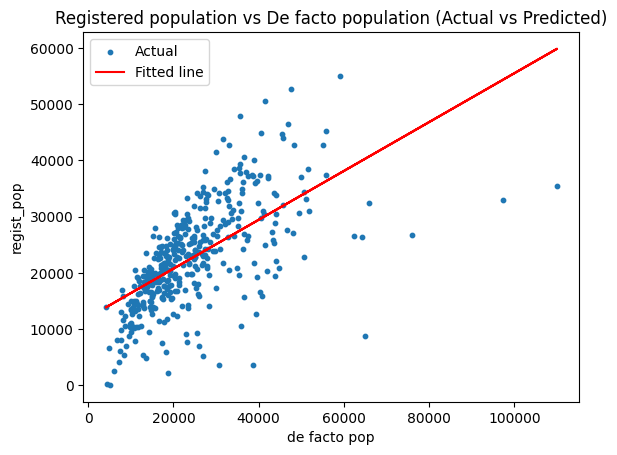

In [ ]:
# Calculate predicted values
merged_df_Seoul['predicted'] = results.predict(X)
plt.scatter(merged_df_Seoul['All_pop'], merged_df_Seoul['regist_pop'], s=10, label='Actual')
plt.plot(merged_df_Seoul['All_pop'], merged_df_Seoul['predicted'], color='red', label='Fitted line')
plt.xlabel('de facto pop')
plt.ylabel('regist_pop')
plt.title('Registered population vs De facto population (Actual vs Predicted)')
plt.legend()
plt.show()

In [ ]:
#@title Regression y=LN(registered pop(log_regist_pop), x= total de facto pop (log_All_pop)
# Replace drop any rows containing NaN
merged_df_Seoul = merged_df_Seoul.dropna()
# Add a constant to the independent values
X = sm.add_constant(merged_df_Seoul['log_All_pop'])
# Create a model
model = sm.OLS(merged_df_Seoul['log_regist_pop'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['log_All_pop']
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_regist_pop   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     249.2
Date:                Thu, 12 Dec 2024   Prob (F-statistic):           2.78e-44
Time:                        07:17:24   Log-Likelihood:                -264.76
No. Observations:                 416   AIC:                             533.5
Df Residuals:                     414   BIC:                             541.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.8555      0.448      6.371      

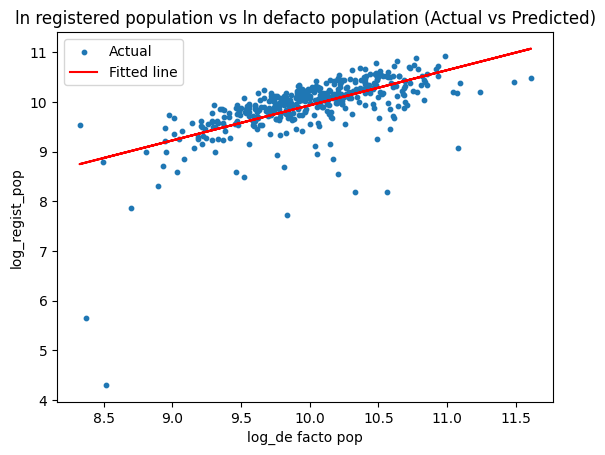

In [ ]:
# Calculate predicted values
merged_df_Seoul['predicted'] = results.predict(X)

# Calculate residuals
merged_df_Seoul['residuals'] = merged_df_Seoul['log_regist_pop']- merged_df_Seoul['predicted']

# Plot the scatter plot and fitted line
plt.scatter(merged_df_Seoul['log_All_pop'], merged_df_Seoul['log_regist_pop'], s=10, label='Actual')
plt.plot(merged_df_Seoul['log_All_pop'], merged_df_Seoul['predicted'], color='red', label='Fitted line')
plt.xlabel('log_de facto pop')
plt.ylabel('log_regist_pop')
plt.title('ln registered population vs ln defacto population (Actual vs Predicted)')
plt.legend()
plt.show()

In [ ]:
# Display observations with very negative residuals
threshold = merged_df_Seoul['residuals'].quantile(0.05)  # For example, the 5th percentile
very_negative_residuals = merged_df_Seoul.loc[merged_df_Seoul['residuals'] < threshold, ['log_All_pop','log_regist_pop', 'FULL_NM', 'residuals']]

print("Observations with very negative residuals:")
print(very_negative_residuals)

Observations with very negative residuals:
     log_All_pop  log_regist_pop                FULL_NM  residuals
3       8.373899        5.645447         서울특별시 서초구 반포본동  -3.134555
43     10.615946        9.669852        서울특별시 서대문구 북아현동  -0.696396
50      8.518542        4.304065         서울특별시 강동구 둔촌1동  -4.578272
149     9.036088        8.594154         서울특별시 종로구 창신1동  -0.654346
195     8.698536        7.869402          서울특별시 종로구 삼청동  -1.140281
275     8.898722        8.314832          서울특별시 종로구 가회동  -0.836481
294     9.464916        8.591187           서울특별시 중구 장충동  -0.960708
325    10.036855        9.112948           서울특별시 중구 신당동  -0.843593
356     9.759285        8.929568          서울특별시 용산구 남영동  -0.830593
364     9.833007        7.723120          서울특별시 중구 을지로동  -2.089199
365     9.522309        8.485703            서울특별시 중구 필동  -1.106798
380     9.813495        8.682029      서울특별시 종로구 종로5.6가동  -1.116485
382    10.054909        8.942592          서울특별시 종로구 이화동  -1.026723
394    10.489736   

In [ ]:
merged_df_Seoul.columns

Index(['Unnamed: 0', 'O_ADMDONG_CD', 'Self-Containment', 'Pull-Effect',
       'FULL_NM', 'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM',
       'full_dong_name', 'gu', 'dong', 'dong_cd', 'HH', 'regist_pop',
       'regist_pop_per_HH', 'elderly_over_65', 'AREA_km2', 'pop_density',
       'Average income', 'Total Spending', 'inv_rank', 'log_inv_rank',
       'log_Pull_Effect', 'residuals', 'predicted', 'All_pop', 'pop_day',
       'pop_even', 'pop_night', '_merge', 'log_All_pop', 'log_pop_day',
       'log_pop_even', 'log_pop_night', 'log_regist_pop'],
      dtype='object')

In [ ]:
#@title y=ln(pull) vs x = ln(defacto pop - registered pop)

# calculate ln(diff_pop) = ln(defacto pop - registered pop)
merged_df_Seoul.loc[:, 'diff_pop'] = merged_df_Seoul.loc[:, 'All_pop'] - merged_df_Seoul.loc[:, 'regist_pop']
merged_df_Seoul.loc[:, 'log_diff_pop'] = np.log(merged_df_Seoul['diff_pop'])

# Replace drop any rows containing NaN
merged_df_Seoul = merged_df_Seoul.dropna()

# Add a constant to the independent values
X = sm.add_constant(merged_df_Seoul['log_diff_pop'])

# Create a model
model = sm.OLS(merged_df_Seoul['log_Pull_Effect'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['log_diff_pop']
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     120.4
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           4.97e-22
Time:                        08:43:40   Log-Likelihood:                -152.53
No. Observations:                 193   AIC:                             309.1
Df Residuals:                     191   BIC:                             315.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.8560      0.246    -19.745   

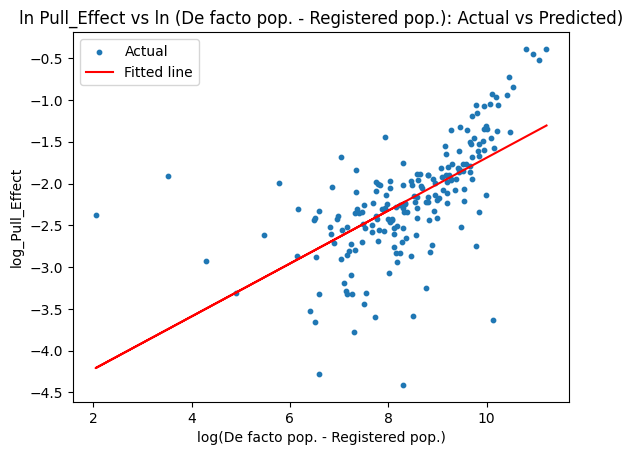

In [ ]:
# Calculate predicted values
merged_df_Seoul['predicted'] = results.predict(X)
plt.scatter(merged_df_Seoul['log_diff_pop'], merged_df_Seoul['log_Pull_Effect'], s=10, label='Actual')
plt.plot(merged_df_Seoul['log_diff_pop'], merged_df_Seoul['predicted'], color='red', label='Fitted line')
plt.xlabel('log(De facto pop. - Registered pop.)')
plt.ylabel('log_Pull_Effect')
plt.title('ln Pull_Effect vs ln (De facto pop. - Registered pop.): Actual vs Predicted)')
plt.legend()
plt.show()

In [ ]:
#@title Regression y=log_PE and log de facto(day+evening time)
merged_df_Seoul.loc[:, 'pop_day_even'] = (merged_df_Seoul.loc[:, 'pop_day'] + merged_df_Seoul.loc[:, 'pop_even'])/2
merged_df_Seoul.loc[:,'log_pop_day_even'] = np.log(merged_df_Seoul['pop_day_even'])

# Replace drop any rows containing NaN
merged_df_Seoul = merged_df_Seoul.dropna()

# Add a constant to the independent values
X = sm.add_constant(merged_df_Seoul['log_pop_day_even'])

# Create a model
model = sm.OLS(merged_df_Seoul['log_Pull_Effect'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['log_pop_day_even']
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     961.6
Date:                Tue, 10 Dec 2024   Prob (F-statistic):          5.29e-110
Time:                        01:43:51   Log-Likelihood:                -225.57
No. Observations:                 416   AIC:                             455.1
Df Residuals:                     414   BIC:                             463.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -14.7781      0.390  

In [ ]:
# Replace drop any rows containing NaN
merged_df_Seoul = merged_df_Seoul.dropna()

# Add a constant to the independent values
X = sm.add_constant(merged_df_Seoul['log_regist_pop'])

# Create a model
model = sm.OLS(merged_df_Seoul['log_Pull_Effect'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['log_regist_pop']

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     22.81
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           2.49e-06
Time:                        01:25:47   Log-Likelihood:                -464.17
No. Observations:                 416   AIC:                             932.3
Df Residuals:                     414   BIC:                             940.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -5.6623      0.623     -9.

In [ ]:
# Replace drop any rows containing NaN
merged_df_Seoul = merged_df_Seoul.dropna()

# Add a constant to the independent values
X = sm.add_constant(merged_df_Seoul['log_regist_pop'])

# Create a model
model = sm.OLS(merged_df_Seoul['log_Pull_Effect'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['log_regist_pop']

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     22.81
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           2.49e-06
Time:                        07:00:58   Log-Likelihood:                -464.17
No. Observations:                 416   AIC:                             932.3
Df Residuals:                     414   BIC:                             940.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -5.6623      0.623     -9.

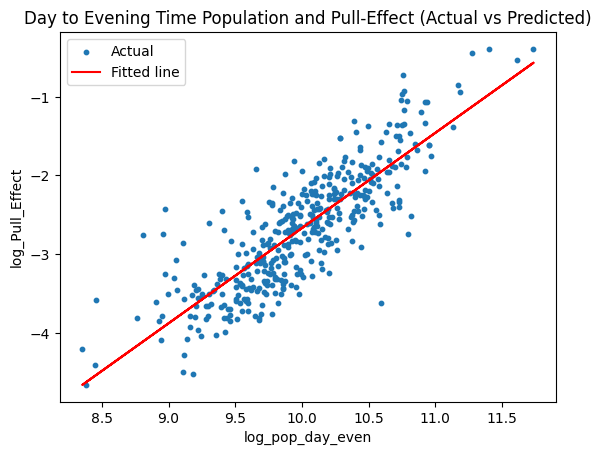

In [ ]:
# Calculate predicted values
merged_df_Seoul['predicted'] = results.predict(X)

plt.scatter(merged_df_Seoul['log_pop_day_even'], merged_df_Seoul['log_Pull_Effect'], s=10, label='Actual')
plt.plot(merged_df_Seoul['log_pop_day_even'], merged_df_Seoul['predicted'], color='red', label='Fitted line')
plt.xlabel('log_pop_day_even')
plt.ylabel('log_Pull_Effect')
plt.title('Day to Evening Time Population and Pull-Effect (Actual vs Predicted)')
plt.legend()
plt.show()

<ipython-input-129-60c251a929ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_Seoul['predicted'] = results.predict(X)


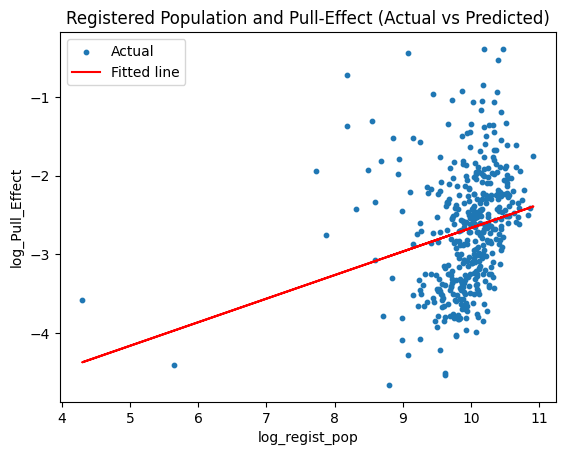

In [ ]:
# Calculate predicted values
merged_df_Seoul['predicted'] = results.predict(X)

plt.scatter(merged_df_Seoul['log_regist_pop'], merged_df_Seoul['log_Pull_Effect'], s=10, label='Actual')
plt.plot(merged_df_Seoul['log_regist_pop'], merged_df_Seoul['predicted'], color='red', label='Fitted line')
plt.xlabel('log_regist_pop')
plt.ylabel('log_Pull_Effect')
plt.title('Registered Population and Pull-Effect (Actual vs Predicted)')
plt.legend()
plt.show()

In [ ]:
merged_df.columns

Index(['O_ADMDONG_CD', 'Self-Containment', 'Pull-Effect', 'FULL_NM',
       'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM', 'full_dong_name', 'gu',
       'dong', 'dong_cd', 'HH', 'regist_pop', 'regist_pop_per_HH',
       'elderly_over_65', 'AREA_km2', 'pop_density', 'Average income',
       'Total Spending', 'inv_rank', 'log_inv_rank', 'log_Pull_Effect',
       'residuals', 'predicted', 'All_pop', 'pop_day', 'pop_even', 'pop_night',
       '_merge', 'log_All_pop', 'log_pop_day', 'log_pop_even',
       'log_pop_night'],
      dtype='object')

In [ ]:
# Replace drop any rows containing NaN
merged_df_Seoul = merged_df_Seoul.dropna()

# Add a constant to the independent values
X = sm.add_constant(merged_df_Seoul['log_All_pop'])

# Create a model
model = sm.OLS(merged_df_Seoul['log_Pull_Effect'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['log_All_pop']

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     703.3
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           2.77e-91
Time:                        06:46:40   Log-Likelihood:                -268.83
No. Observations:                 416   AIC:                             541.7
Df Residuals:                     414   BIC:                             549.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -14.6789      0.453    -32.430      

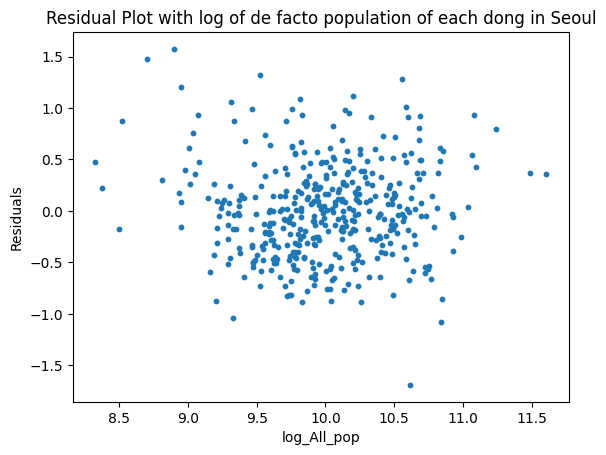

In [ ]:
import matplotlib.pyplot as plt

# Calculate the residuals
merged_df_Seoul['residuals'] = results.resid

# Create a scatter plot
plt.scatter(merged_df_Seoul['log_All_pop'], merged_df_Seoul['residuals'], s=10)
plt.xlabel('log_All_pop')
plt.ylabel('Residuals')
plt.title('Residual Plot with log of de facto population of each dong in Seoul')
plt.show()

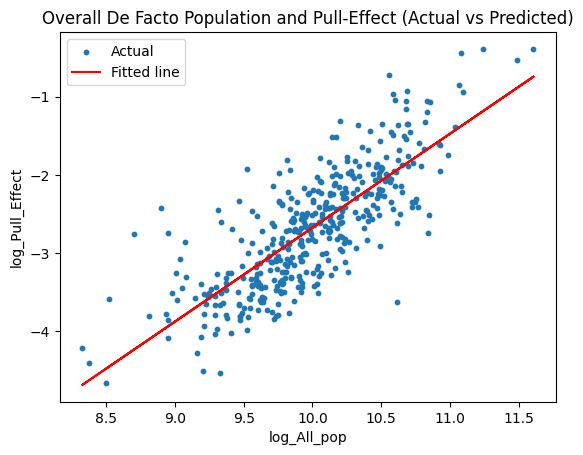

In [ ]:
# Calculate predicted values
merged_df_Seoul['predicted'] = results.predict(X)

plt.scatter(merged_df_Seoul['log_All_pop'], merged_df_Seoul['log_Pull_Effect'], s=10, label='Actual')
plt.plot(merged_df_Seoul['log_All_pop'], merged_df_Seoul['predicted'], color='red', label='Fitted line')
plt.xlabel('log_All_pop')
plt.ylabel('log_Pull_Effect')
plt.title('Overall De Facto Population and Pull-Effect (Actual vs Predicted)')
plt.legend()
plt.show()

In [ ]:
merged_df_Seoul.columns

Index(['O_ADMDONG_CD', 'Self-Containment', 'Pull-Effect', 'FULL_NM',
       'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM', 'full_dong_name', 'gu',
       'dong', 'dong_cd', 'HH', 'regist_pop', 'regist_pop_per_HH',
       'elderly_over_65', 'AREA_km2', 'pop_density', 'Average income',
       'Total Spending', 'inv_rank', 'log_inv_rank', 'log_Pull_Effect',
       'residuals', 'predicted', 'All_pop', 'pop_day', 'pop_even', 'pop_night',
       '_merge', 'log_All_pop', 'log_pop_day', 'log_pop_even',
       'log_pop_night'],
      dtype='object')

In [ ]:
# Add a constant to the independent values
X = sm.add_constant(merged_df_Seoul['log_pop_day'])

# Create a model
model = sm.OLS(merged_df_Seoul['log_Pull_Effect'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['log_pop_day']

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     1565.
Date:                Fri, 25 Oct 2024   Prob (F-statistic):          9.62e-143
Time:                        06:37:57   Log-Likelihood:                -149.88
No. Observations:                 416   AIC:                             303.8
Df Residuals:                     414   BIC:                             311.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -14.3525      0.295    -48.611      

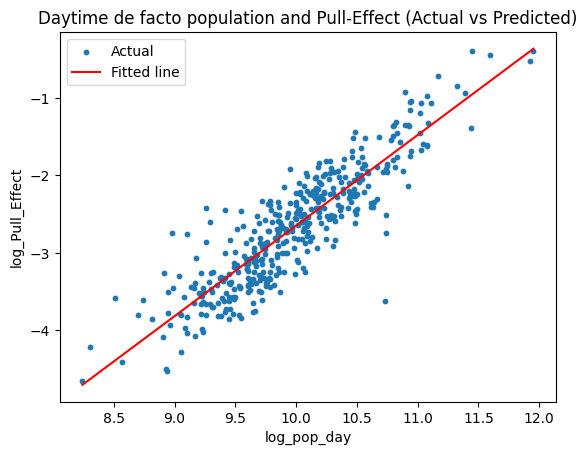

In [ ]:
# Calculate predicted values
merged_df_Seoul['predicted'] = results.predict(X)

plt.scatter(merged_df_Seoul['log_pop_day'], merged_df_Seoul['log_Pull_Effect'], s=10, label='Actual')
plt.plot(merged_df_Seoul['log_pop_day'], merged_df_Seoul['predicted'], color='red', label='Fitted line')
plt.xlabel('log_pop_day')
plt.ylabel('log_Pull_Effect')
plt.title('Daytime de facto population and Pull-Effect (Actual vs Predicted)')
plt.legend()
plt.show()

In [ ]:
#@title evening time pop.
# Add a constant to the independent values
X = sm.add_constant(merged_df_Seoul['log_pop_even'])

# Create a model
model = sm.OLS(merged_df_Seoul['log_Pull_Effect'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['log_pop_even']

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     440.4
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           3.99e-67
Time:                        06:40:53   Log-Likelihood:                -324.63
No. Observations:                 416   AIC:                             653.3
Df Residuals:                     414   BIC:                             661.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -13.7813      0.529    -26.045   

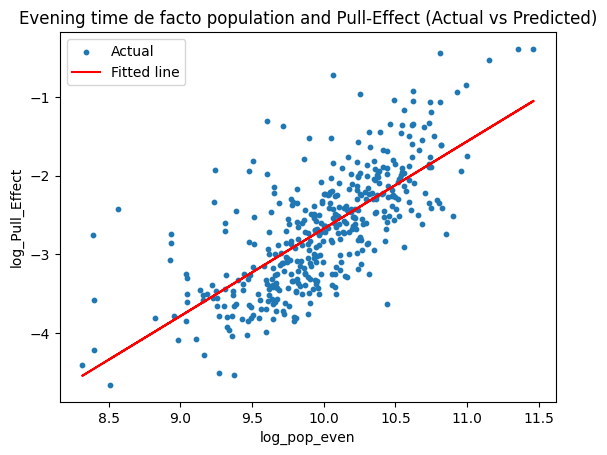

In [ ]:
# Calculate predicted values
merged_df_Seoul['predicted'] = results.predict(X)

plt.scatter(merged_df_Seoul['log_pop_even'], merged_df_Seoul['log_Pull_Effect'], s=10, label='Actual')
plt.plot(merged_df_Seoul['log_pop_even'], merged_df_Seoul['predicted'], color='red', label='Fitted line')
plt.xlabel('log_pop_even')
plt.ylabel('log_Pull_Effect')
plt.title('Evening time de facto population and Pull-Effect (Actual vs Predicted)')
plt.legend()
plt.show()

In [ ]:
#@title night time pop.
# Add a constant to the independent values
X = sm.add_constant(merged_df_Seoul['log_pop_night'])

# Create a model
model = sm.OLS(merged_df_Seoul['log_Pull_Effect'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['log_pop_night']

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     154.4
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           2.43e-30
Time:                        06:56:42   Log-Likelihood:                -409.42
No. Observations:                 416   AIC:                             822.8
Df Residuals:                     414   BIC:                             830.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -10.8625      0.659    -16.495

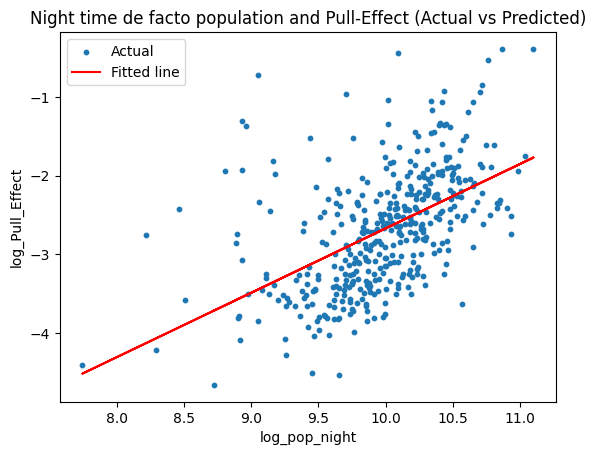

In [ ]:
# Calculate predicted values
merged_df_Seoul['predicted'] = results.predict(X)

plt.scatter(merged_df_Seoul['log_pop_night'], merged_df_Seoul['log_Pull_Effect'], s=10, label='Actual')
plt.plot(merged_df_Seoul['log_pop_night'], merged_df_Seoul['predicted'], color='red', label='Fitted line')
plt.xlabel('log_pop_night')
plt.ylabel('log_Pull_Effect')
plt.title('Night time de facto population and Pull-Effect (Actual vs Predicted)')
plt.legend()
plt.show()

In [ ]:
merged_df_Seoul.columns

Index(['O_ADMDONG_CD', 'Self-Containment', 'Pull-Effect', 'FULL_NM',
       'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM', 'full_dong_name', 'gu',
       'dong', 'dong_cd', 'HH', 'regist_pop', 'regist_pop_per_HH',
       'elderly_over_65', 'AREA_km2', 'pop_density', 'Average income',
       'Total Spending', 'inv_rank', 'log_inv_rank', 'log_Pull_Effect',
       'residuals', 'predicted', 'All_pop', 'pop_day', 'pop_even', 'pop_night',
       '_merge', 'log_All_pop', 'log_pop_day', 'log_pop_even', 'log_pop_night',
       'log_regist_pop'],
      dtype='object')

In [ ]:
#@title High Pull-effect group
merged_df_Seoul.loc[merged_df_Seoul['Pull-Effect']>0.45, :]

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM,full_dong_name,gu,...,All_pop,pop_day,pop_even,pop_night,_merge,log_All_pop,log_pop_day,log_pop_even,log_pop_night,log_regist_pop
421,11140550,0.212338,0.485623,서울특별시 중구 명동,서울특별시 중구,서울특별시,중구,명동,중구명동,중구,...,38575.639415,70742.431096,23464.500691,8507.169548,both,10.560376,11.166801,10.063244,9.048665,8.188689
422,11560540,0.317986,0.590718,서울특별시 영등포구 여의동,서울특별시 영등포구,서울특별시,영등포구,여의동,영등포구여의동,영등포구,...,97394.180565,150753.694499,69769.608850,46997.121820,both,11.486522,11.923403,11.152954,10.757842,10.400285
423,11110615,0.262373,0.639357,서울특별시 종로구 종로1.2.3.4가동,서울특별시 종로구,서울특별시,종로구,종로1.2.3.4가동,종로구종로1.2.3.4가동,종로구,...,64864.387216,108365.191435,49428.080512,24040.649098,both,11.080054,11.593262,10.808274,10.087501,9.072342
424,11440660,0.209375,0.677243,서울특별시 마포구 서교동,서울특별시 마포구,서울특별시,마포구,서교동,마포구서교동,마포구,...,76096.307494,93343.344839,85603.520681,52172.347508,both,11.239755,11.444040,11.357482,10.862308,10.190657
425,11680640,0.217108,0.677788,서울특별시 강남구 역삼1동,서울특별시 강남구,서울특별시,강남구,역삼1동,강남구역삼1동,강남구,...,109974.031906,155043.443360,95071.614912,66002.655480,both,11.608000,11.951461,11.462386,11.097450,10.474721


In [ ]:
#@title High self-containment group
merged_df_Seoul.loc[merged_df_Seoul['Self-Containment']>0.3, :]

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM,full_dong_name,gu,...,All_pop,pop_day,pop_even,pop_night,_merge,log_All_pop,log_pop_day,log_pop_even,log_pop_night,log_regist_pop
240,11290640,0.356556,0.077714,서울특별시 성북구 정릉3동,서울특별시 성북구,서울특별시,성북구,정릉3동,성북구정릉3동,성북구,...,19094.586410,21821.898075,17123.386863,17329.315912,both,9.857160,9.990669,9.748200,9.760155,9.719445
257,11350560,0.333550,0.082080,서울특별시 노원구 월계1동,서울특별시 노원구,서울특별시,노원구,월계1동,노원구월계1동,노원구,...,23686.936671,23528.630731,23968.841846,23898.649845,both,10.072679,10.065973,10.084510,10.081577,9.977435
331,11230740,0.378406,0.114640,서울특별시 동대문구 이문1동,서울특별시 동대문구,서울특별시,동대문구,이문1동,동대문구이문1동,동대문구,...,27904.426422,29855.608564,26274.361031,26650.461610,both,10.236541,10.304128,10.176349,10.190562,9.964865
357,11590605,0.405991,0.138812,서울특별시 동작구 흑석동,서울특별시 동작구,서울특별시,동작구,흑석동,동작구흑석동,동작구,...,35775.473627,39622.880371,34366.339694,32592.199163,both,10.485018,10.587162,10.444833,10.391828,10.342387
366,11620735,0.320609,0.147390,서울특별시 관악구 대학동,서울특별시 관악구,서울특별시,관악구,대학동,관악구대학동,관악구,...,36659.886710,46048.818373,31497.046873,29863.790871,both,10.509438,10.737457,10.357649,10.304402,10.198803
375,11110650,0.394115,0.155762,서울특별시 종로구 혜화동,서울특별시 종로구,서울특별시,종로구,혜화동,종로구혜화동,종로구,...,35294.765343,38605.792142,36147.744966,31221.592087,both,10.471490,10.561158,10.495370,10.348865,9.881753
378,11290600,0.388642,0.161417,서울특별시 성북구 안암동,서울특별시 성북구,서울특별시,성북구,안암동,성북구안암동,성북구,...,29914.945263,36693.341670,27717.682035,23300.668213,both,10.306113,10.510351,10.229826,10.056237,9.755451
383,11200550,0.392416,0.170615,서울특별시 성동구 사근동,서울특별시 성동구,서울특별시,성동구,사근동,성동구사근동,성동구,...,28382.248922,34801.464567,26011.002283,21912.048896,both,10.253519,10.457415,10.166275,9.994792,9.548240
386,11380690,0.368133,0.174057,서울특별시 은평구 진관동,서울특별시 은평구,서울특별시,은평구,진관동,은평구진관동,은평구,...,59061.920710,55960.692900,60018.178008,61896.410164,both,10.986342,10.932405,11.002403,11.033217,10.915870
420,11410585,0.444848,0.428060,서울특별시 서대문구 신촌동,서울특별시 서대문구,서울특별시,서대문구,신촌동,서대문구신촌동,서대문구,...,64154.086789,82607.559750,59394.678552,45206.108673,both,11.069043,11.321856,10.991960,10.718988,10.183200
